<p style="font-family: Times New Roman;font-size:35px;color:Maroon">Network-Analysis-Policy-Intervention</p>


In [63]:
# Then import all the required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
import networkx as nx

In [65]:
nodes = pd.read_csv("nodes_cluster_F.csv" , sep = ";")
nodes.head()

,id,coord,core,gender
0,71645,0,1,0
1,8054,0,1,0
2,3723,0,0,0
3,8147,0,0,0
4,8141,0,1,1


In [67]:
edges = pd.read_csv("edges_cluster_F.csv" , sep = ";")
edges.head()

,source,target,pre_link,post_link
0,71645,1885,0,1
1,8054,1948,1,1
2,3723,1948,1,1
3,8158,2962,0,1
4,92218,2962,0,1


In [69]:
# Identifier les liens bilatéraux et créer une colonne unique pour chaque lien
edges['link_id'] = edges.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)

# Compter les occurrences de chaque lien
link_counts = edges['link_id'].value_counts()
print(f"Nombre de liens uniques: {link_counts.size}")
print(f"Nombre de liens bilatéraux (apparaissant 2 fois): {sum(link_counts == 2)}")

# Filtrer pour ne garder qu'une version unique de chaque lien
edges_unique = edges.drop_duplicates(subset=['link_id']).drop(columns=['link_id'])
print(f"Nombre de lignes après suppression des doublons: {len(edges_unique)}")

# Créer une version canonique des liens (source < target)
edges_canonical = edges.assign(
    source=edges['link_id'].apply(lambda x: x[0]),
    target=edges['link_id'].apply(lambda x: x[1])
).drop_duplicates(subset=['source', 'target']).drop(columns=['link_id'])
print(f"Nombre de lignes dans la version canonique: {len(edges_canonical)}")

# Vérifier les liens unidirectionnels
single_links = link_counts[link_counts == 1]
if not single_links.empty:
    print(f"\nAttention: {len(single_links)} liens n'apparaissent qu'une seule fois!")
    print("Exemples de ces liens unidirectionnels:")
    print(edges[edges['link_id'].isin(single_links.index)].head())


Nombre de liens uniques: 1606
Nombre de liens bilatéraux (apparaissant 2 fois): 1606
Nombre de lignes après suppression des doublons: 1606
Nombre de lignes dans la version canonique: 1606


### 1) Analyse de la structure du réseau

In [72]:
# Création du réseau pré-traitement
G_pre = nx.Graph()
G_pre.add_nodes_from(nodes['id'])
pre_edges = edges_unique[edges_unique['pre_link'] == 1]
G_pre.add_edges_from([(row['source'], row['target']) for _, row in pre_edges.iterrows()])

# Création du réseau post-traitement
G_post = nx.Graph()
G_post.add_nodes_from(nodes['id'])
post_edges = edges_unique[edges_unique['post_link'] == 1]
G_post.add_edges_from([(row['source'], row['target']) for _, row in post_edges.iterrows()])

# Ajout des attributs aux nœuds
for _, row in nodes.iterrows():
    node_id = row['id']
    if node_id in G_pre.nodes():
        G_pre.nodes[node_id]['gender'] = row['gender']
        G_pre.nodes[node_id]['core'] = row['core']
        G_pre.nodes[node_id]['coord'] = row['coord']
    if node_id in G_post.nodes():
        G_post.nodes[node_id]['gender'] = row['gender']
        G_post.nodes[node_id]['core'] = row['core']
        G_post.nodes[node_id]['coord'] = row['coord']

# Vérification des réseaux créés
print("\nRéseau pré-traitement:")
print(f"Nombre de nœuds: {G_pre.number_of_nodes()}")
print(f"Nombre de liens: {G_pre.number_of_edges()}")

print("\nRéseau post-traitement:")
print(f"Nombre de nœuds: {G_post.number_of_nodes()}")
print(f"Nombre de liens: {G_post.number_of_edges()}")


Réseau pré-traitement:
Nombre de nœuds: 310
Nombre de liens: 869

Réseau post-traitement:
Nombre de nœuds: 310
Nombre de liens: 1258


In [74]:
# Vérification concise des attributs des deux premiers nœuds
first_two_ids = list(nodes['id'])[:2]

print("Dans le dataframe nodes:")
print(nodes[nodes['id'].isin(first_two_ids)])

print("\nDans les réseaux:")
for period, G in [("Pré", G_pre), ("Post", G_post)]:
    print(f"\n{period}-traitement:")
    for node_id in first_two_ids:
        if node_id in G.nodes():
            attrs = G.nodes[node_id]
            print(f"Nœud {node_id}: gender={attrs.get('gender')}, core={attrs.get('core')}, "
                  f"coord={attrs.get('coord')}, degré={G.degree(node_id)}")

Dans le dataframe nodes:
      id  coord  core  gender
0  71645      0     1       0
1   8054      0     1       0

Dans les réseaux:

Pré-traitement:
Nœud 71645: gender=0, core=1, coord=0, degré=2
Nœud 8054: gender=0, core=1, coord=0, degré=4

Post-traitement:
Nœud 71645: gender=0, core=1, coord=0, degré=4
Nœud 8054: gender=0, core=1, coord=0, degré=6


### Objectif n°1

In [77]:
def calculate_network_metrics(G, name):
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    # Préparation pour le calcul du chemin moyen
    largest_cc = max(nx.connected_components(G), key=len)
    largest_G = G.subgraph(largest_cc).copy()
    
    # Toutes les métriques en une seule fois
    metrics = {
        'Réseau': name,
        'Nombre de nœuds (ordre)': n_nodes,
        'Nombre de liens (taille)': n_edges,
        'Degré moyen du réseau': round(2 * n_edges / n_nodes, 3),
        'Densité du réseau': round(nx.density(G), 4),
        'Average local clustering coefficient': round(nx.average_clustering(G), 4),
        'Global clustering coefficient': round(nx.transitivity(G), 4),
        'Average shortest path (plus grande composante)': round(nx.average_shortest_path_length(largest_G), 4),
        '% nœuds dans plus grande composante': round(len(largest_cc) / n_nodes * 100, 2)
    }
    
    return metrics

# Calcul et affichage des métriques
metrics_df = pd.DataFrame([
    calculate_network_metrics(G_pre, "Valeurs avant la politique"),
    calculate_network_metrics(G_post, "Valeurs après la politique")
]).set_index('Réseau')

print("\nStatistiques calculées sur le réseau avant et après la mise en place de la politique:")
print(metrics_df)


Statistiques calculées sur le réseau avant et après la mise en place de la politique:
                            Nombre de nœuds (ordre)  Nombre de liens (taille)  \
Réseau                                                                          
Valeurs avant la politique                      310                       869   
Valeurs après la politique                      310                      1258   

                            Degré moyen du réseau  Densité du réseau  \
Réseau                                                                 
Valeurs avant la politique                  5.606             0.0181   
Valeurs après la politique                  8.116             0.0263   

                            Average local clustering coefficient  \
Réseau                                                             
Valeurs avant la politique                                 0.446   
Valeurs après la politique                                 0.563   

                          

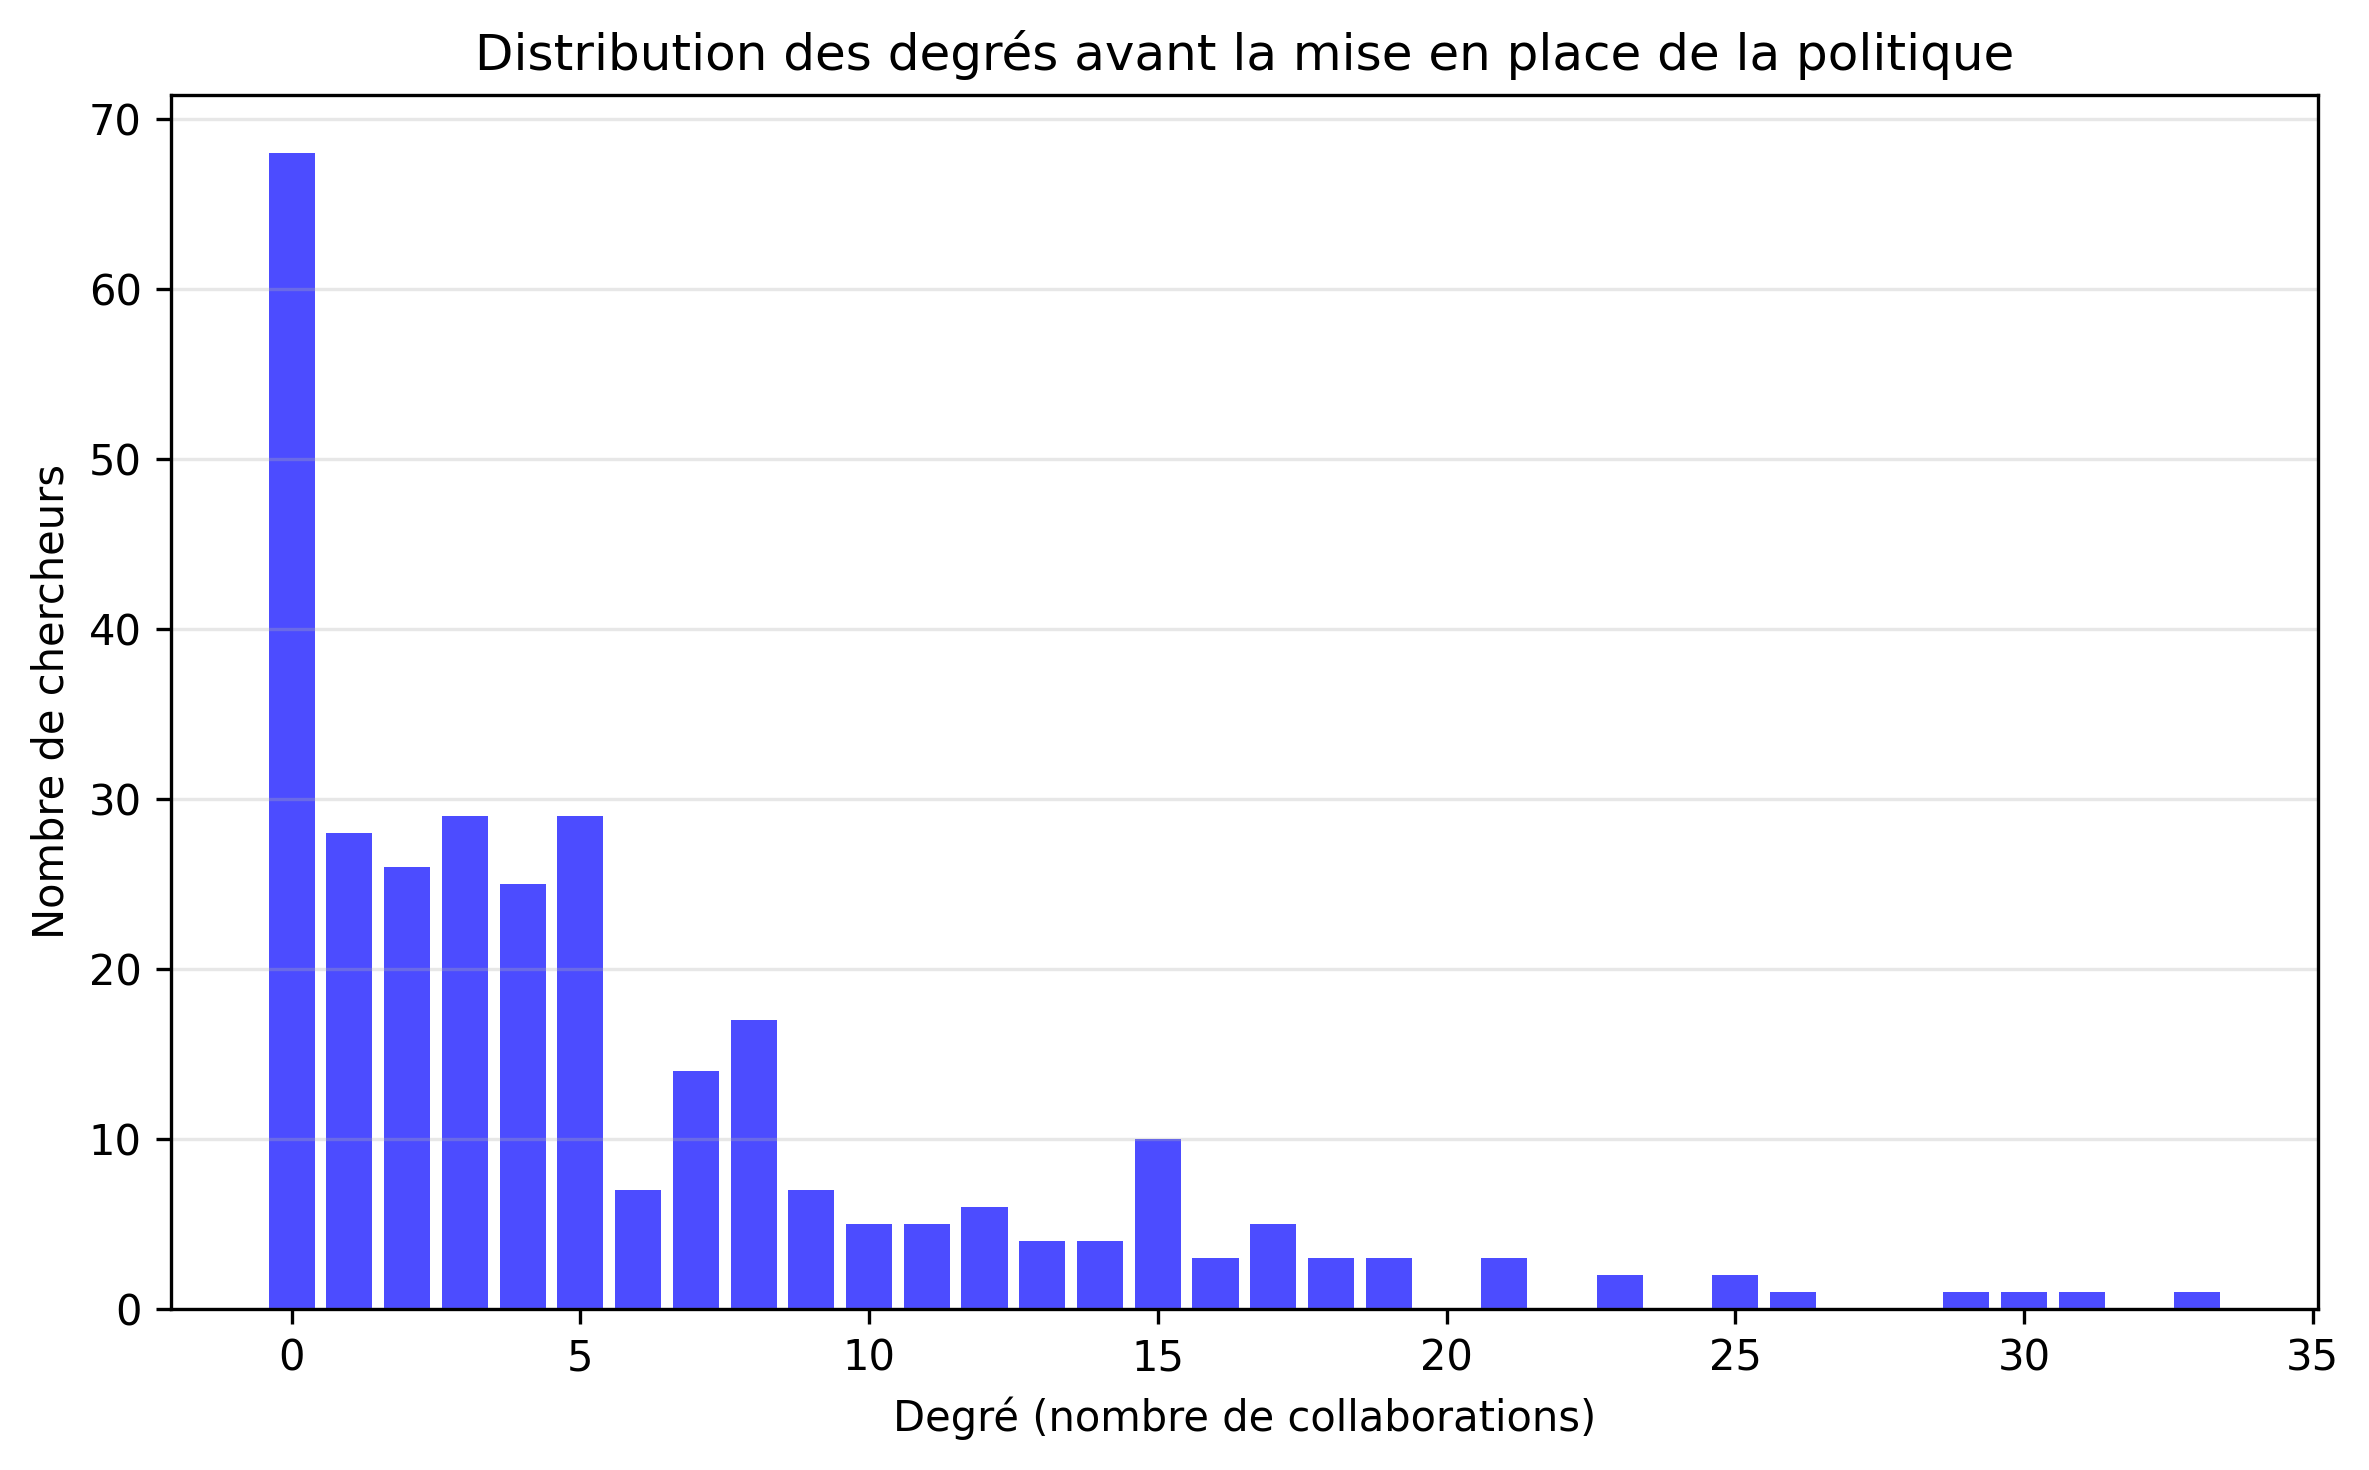

In [79]:
# Distribution des degrés avant la mise en place de la politique
pre_degrees = [d for _, d in G_pre.degree()]
degree_counts = np.unique(pre_degrees, return_counts=True)

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(degree_counts[0], degree_counts[1], color='blue', alpha=0.7)
ax.set_xlabel('Degré (nombre de collaborations)')
ax.set_ylabel('Nombre de chercheurs')
ax.set_title('Distribution des degrés avant la mise en place de la politique')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('degree_distribution_pre.png', dpi=300)
plt.show()

Interprétation de la distribution des degrés avant la mise en place de la politique :
Observation générale :

La majorité des nœuds (chercheurs) ont un degré faible, c'est-à-dire qu'ils ont peu de collaborations. Par exemple, on observe un pic important autour de 0 à 2 collaborations.
Très peu de nœuds ont un degré élevé (au-delà de 15 collaborations), ce qui indique que les collaborations sont concentrées autour de quelques individus très connectés.
Structure du réseau avant la politique :

Le réseau semble être hétérogène, avec une majorité de chercheurs faiblement connectés et une minorité de chercheurs jouant un rôle central (avec un degré élevé).
Cela peut indiquer une structure en "étoile" ou en "hub-and-spoke", où quelques individus très connectés agissent comme des points centraux reliant plusieurs autres.
Implications pour la politique :

Avant la mise en place de la politique, le réseau montre une certaine fragmentation, avec de nombreux chercheurs ayant peu ou pas de collaborations.
La politique pourrait viser à réduire cette fragmentation en augmentant les connexions des chercheurs faiblement connectés, ce qui rendrait le réseau plus inclusif et équilibré.
Lien avec votre projet :

Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, cette distribution initiale sert de point de référence. Vous pourrez comparer cette distribution avec celle après la politique pour voir si les chercheurs faiblement connectés ont bénéficié d'une augmentation de leurs collaborations.

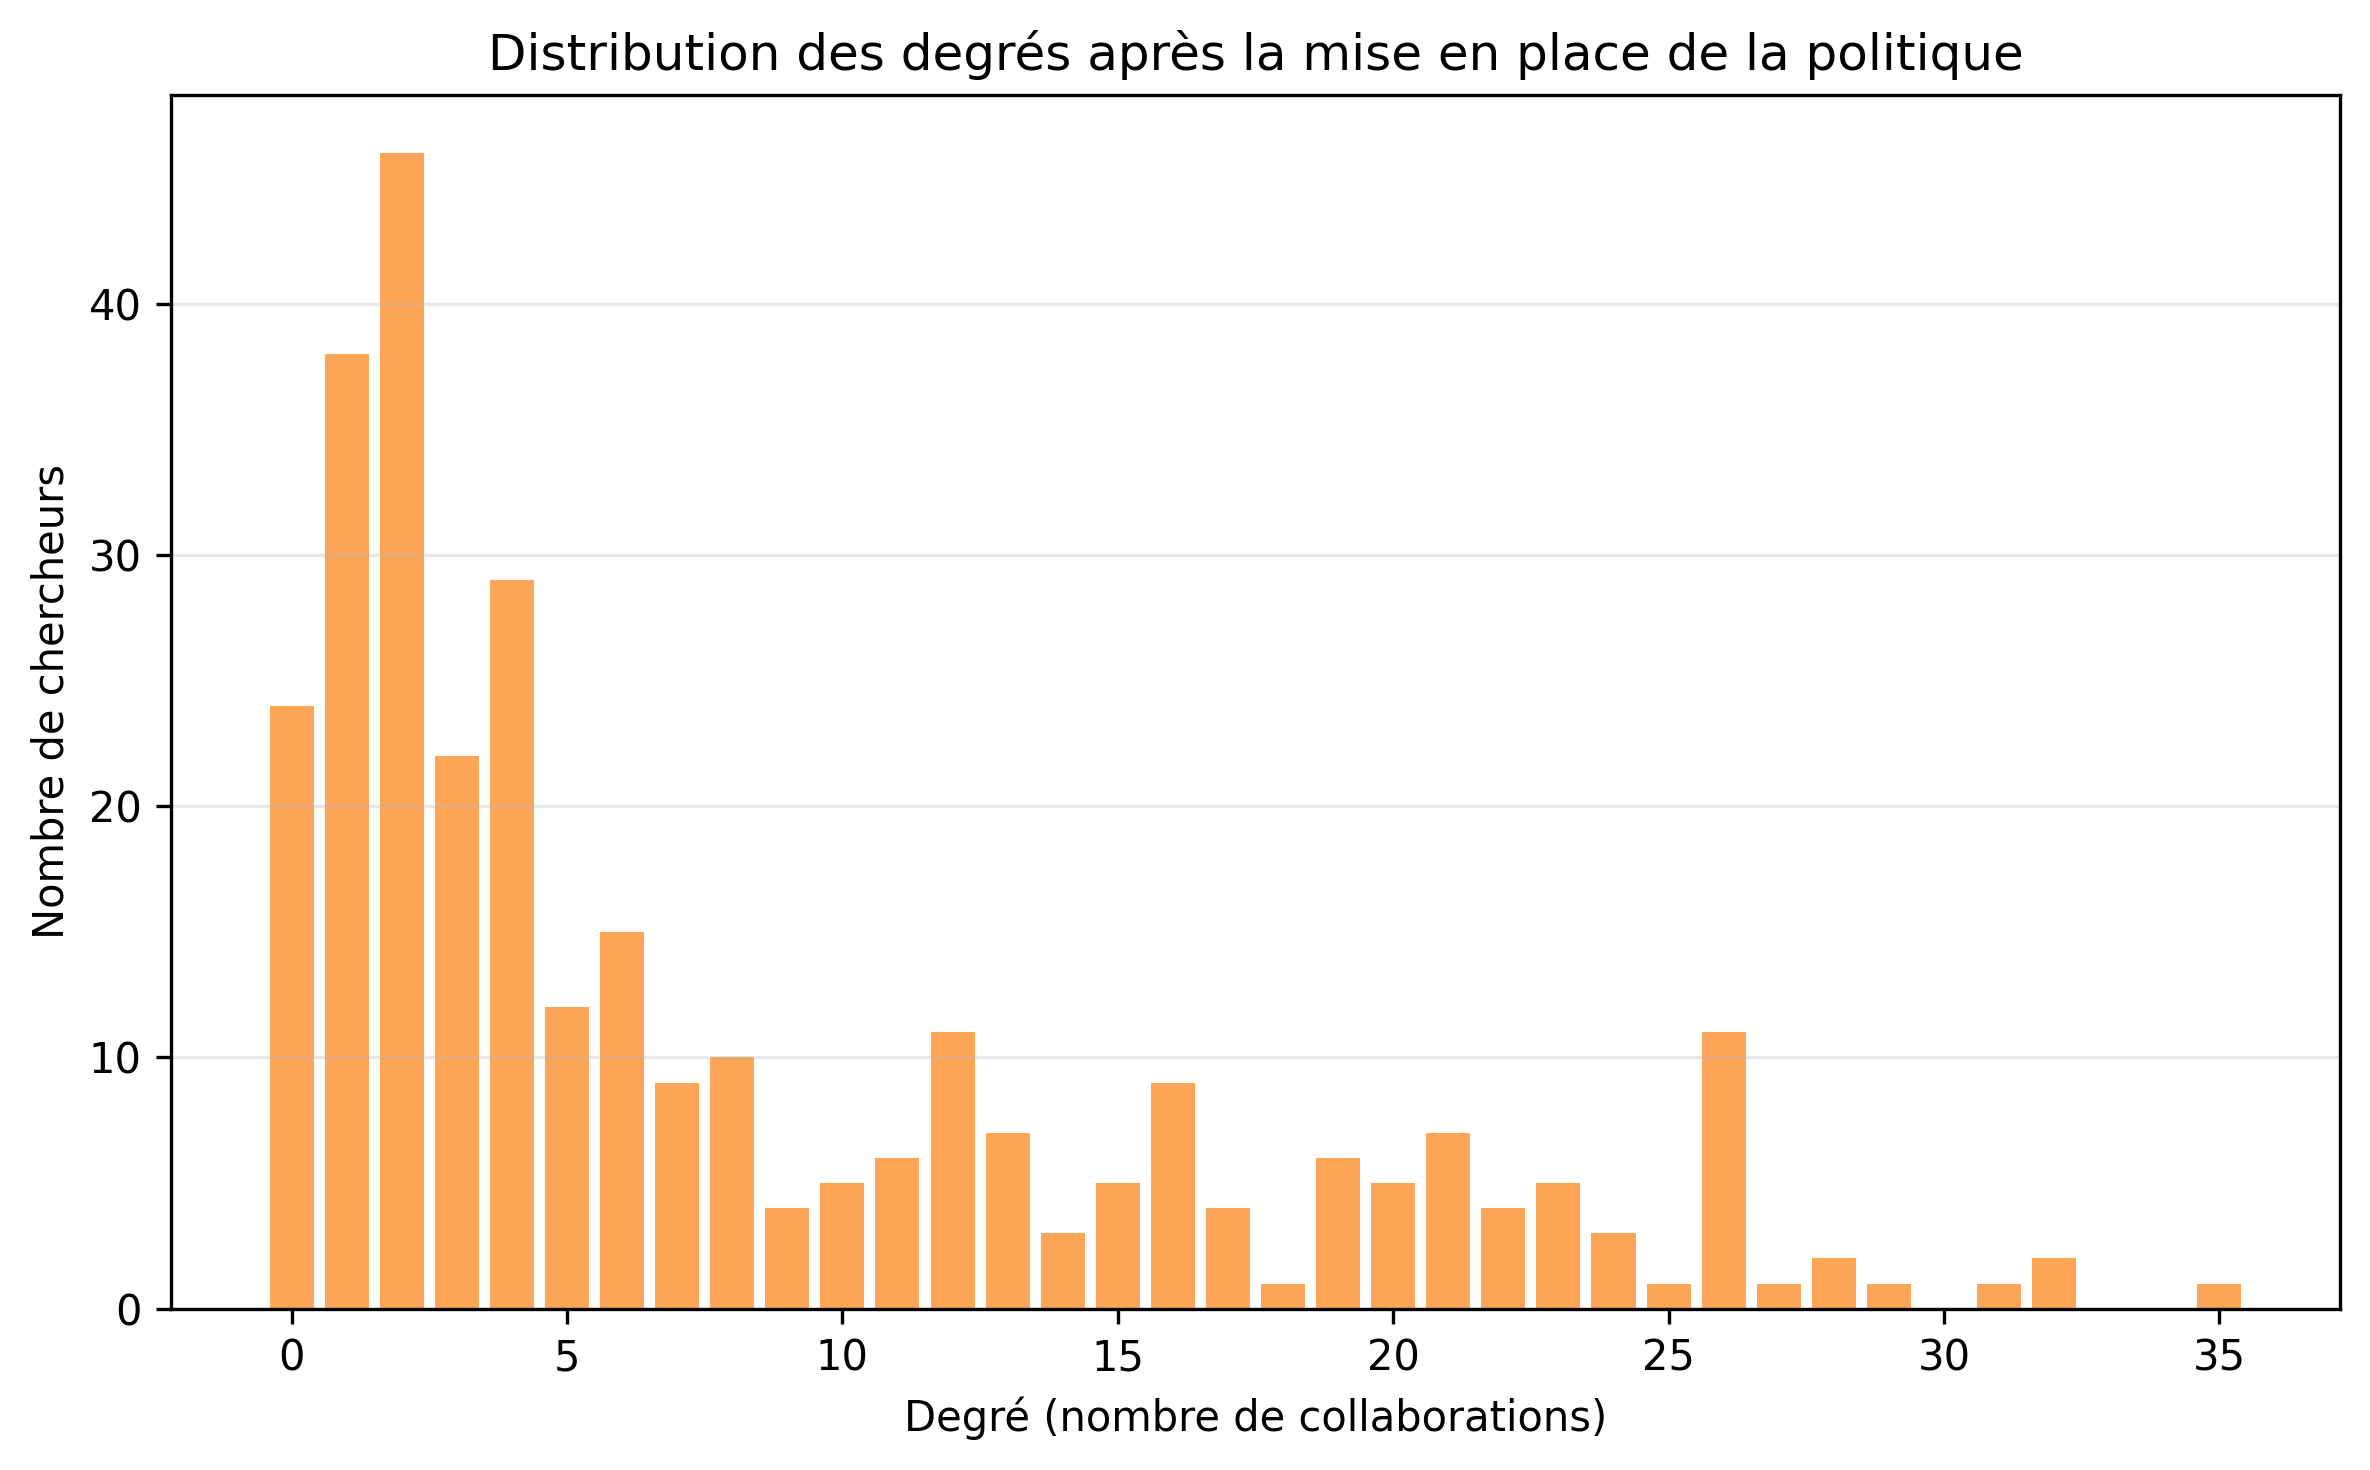

In [81]:
# Distribution des degrés après la mise en place de la politique
post_degrees = [d for _, d in G_post.degree()]
degree_counts = np.unique(post_degrees, return_counts=True)

# Création du graphique
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(degree_counts[0], degree_counts[1], color='tab:orange', alpha=0.7)
plt.xlabel('Degré (nombre de collaborations)')
plt.ylabel('Nombre de chercheurs')
plt.title('Distribution des degrés après la mise en place de la politique')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('degree_distribution_post.png', dpi=300)
plt.show()

### **Interprétation de la distribution des degrés après la mise en place de la politique :**

1. **Observation générale :**
   - La majorité des chercheurs ont un faible degré (entre 0 et 5 collaborations), ce qui est cohérent avec la structure typique des réseaux sociaux où la plupart des individus ont peu de connexions.
   - Cependant, on observe une répartition plus étendue des degrés, avec des chercheurs ayant jusqu'à **30 ou 35 collaborations**, ce qui indique l'existence de nœuds très connectés (hubs).

2. **Structure du réseau :**
   - La présence de chercheurs avec un degré élevé (au-delà de 20 collaborations) montre que certains individus jouent un rôle central dans le réseau, en connectant de nombreux autres chercheurs.
   - Par rapport à la période pré-politique, cette distribution semble indiquer une augmentation des connexions pour plusieurs chercheurs, en particulier ceux qui étaient déjà bien connectés.

3. **Impact de la politique :**
   - La politique semble avoir favorisé une augmentation des collaborations, non seulement pour les chercheurs faiblement connectés, mais aussi pour ceux qui étaient déjà bien intégrés dans le réseau.
   - Cela peut indiquer que la politique a renforcé les hubs existants tout en intégrant davantage de chercheurs faiblement connectés.

4. **Comparaison avec la période pré-politique :**
   - Par rapport à la distribution avant la politique, on peut supposer que :
     - Les chercheurs faiblement connectés (degré 0 à 2) ont vu leur degré augmenter, ce qui réduit la fragmentation du réseau.
     - Les chercheurs déjà bien connectés (degré élevé) ont renforcé leur position, jouant un rôle encore plus central dans le réseau.

5. **Lien avec votre projet :**
   - Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, cette distribution post-politique montre que la politique a eu un effet structurant sur le réseau, en augmentant les connexions globales et en intégrant davantage de chercheurs.
   - Vous pourriez approfondir cette analyse pour déterminer si cet effet est équitable entre les groupes (par exemple, hommes/femmes, core/non-core).

---

### **Conclusion :**
La politique semble avoir eu un effet structurant sur le réseau, en augmentant les connexions globales et en renforçant les collaborations. Cela peut être interprété comme une amélioration de la cohésion et de l'inclusivité du réseau. Pour aller plus loin, il serait intéressant d'examiner si ces changements bénéficient équitablement à tous les groupes ou s'ils renforcent les inégalités existantes.

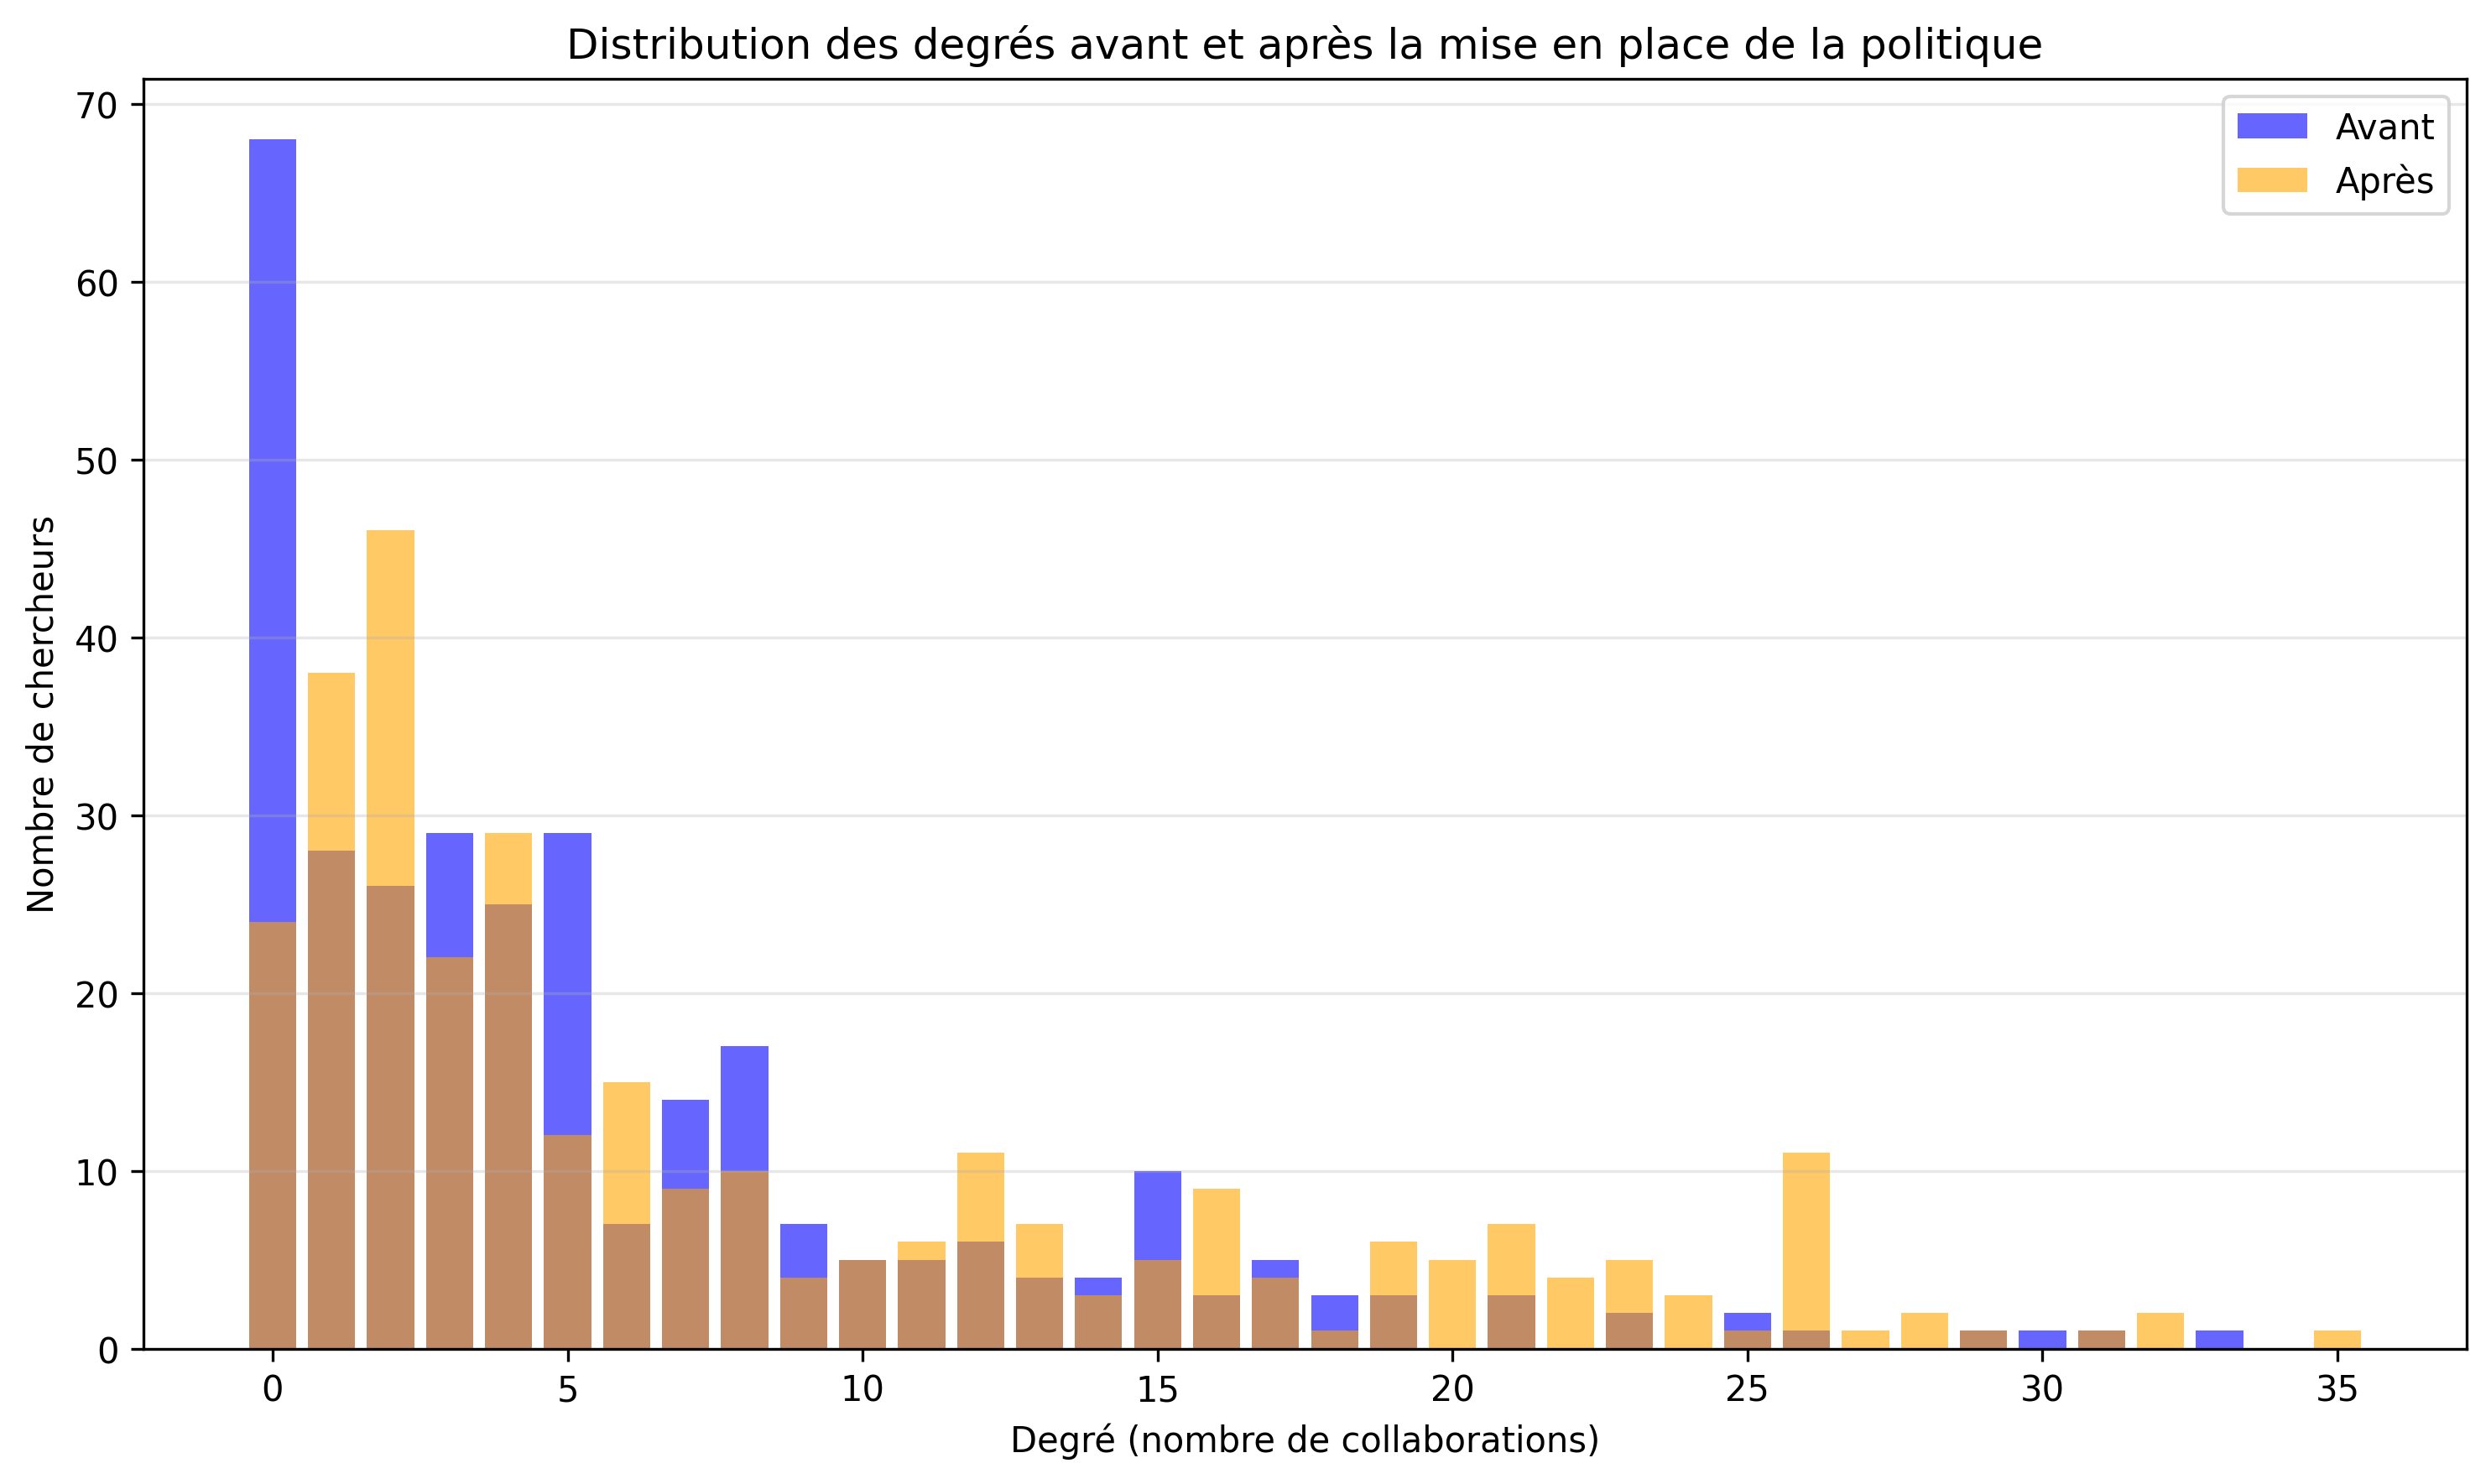

In [85]:
# Distribution des degrés dans le même graphique
degree_count_pre = nx.degree_histogram(G_pre)
degree_count_post = nx.degree_histogram(G_post)

# Assurer que les deux listes ont la même longueur
max_len = max(len(degree_count_pre), len(degree_count_post))
degree_count_pre = degree_count_pre + [0] * (max_len - len(degree_count_pre))
degree_count_post = degree_count_post + [0] * (max_len - len(degree_count_post))

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
degree_range = np.arange(max_len)

ax.bar(degree_range, degree_count_pre, label="Avant", alpha=0.6, color='blue')
ax.bar(degree_range, degree_count_post, label="Après", alpha=0.6, color='orange')

ax.legend(loc="best")
ax.set_xlabel("Degré (nombre de collaborations)")
ax.set_ylabel("Nombre de chercheurs")
ax.set_title("Distribution des degrés avant et après la mise en place de la politique")
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('degree_distribution_comparison.png', dpi=300)
plt.show()

### **Interprétation du graphique : Distribution des degrés avant et après la mise en place de la politique**

1. **Observation générale :**
   - **Avant la politique (barres bleues) :**
     - La majorité des chercheurs ont un faible degré (entre 0 et 5 collaborations).
     - Très peu de chercheurs ont un degré élevé (au-delà de 15 collaborations), ce qui indique une structure fragmentée avec peu de hubs (nœuds très connectés).
   - **Après la politique (barres jaunes) :**
     - On observe une augmentation notable du nombre de chercheurs avec un degré moyen (entre 5 et 15 collaborations).
     - Le nombre de chercheurs avec un degré élevé (au-delà de 20 collaborations) a également augmenté, ce qui montre l'émergence ou le renforcement de hubs.

2. **Impact de la politique :**
   - La politique semble avoir favorisé une augmentation des collaborations globales :
     - Les chercheurs faiblement connectés (degré 0 à 2) ont vu leur degré diminuer, ce qui signifie qu'ils ont été mieux intégrés dans le réseau.
     - Les chercheurs avec un degré moyen ou élevé ont vu leurs connexions augmenter, renforçant leur rôle dans le réseau.
   - Cela reflète une meilleure connectivité et une réduction de la fragmentation du réseau.

3. **Structure du réseau :**
   - Avant la politique, le réseau était plus fragmenté, avec une majorité de chercheurs faiblement connectés.
   - Après la politique, le réseau est devenu plus dense et inclusif, avec une meilleure répartition des connexions entre les chercheurs.

4. **Lien avec votre projet :**
   - Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ce graphique montre que la politique a eu un effet structurant :
     - Elle a permis d'intégrer davantage de chercheurs faiblement connectés.
     - Elle a renforcé les collaborations pour les chercheurs déjà bien connectés.
   - Cela peut être interprété comme une amélioration de la cohésion et de l'inclusivité du réseau.

---

### **Conclusion :**
La politique semble avoir eu un impact positif sur le réseau en augmentant les connexions globales et en réduisant la fragmentation. Elle a permis d'intégrer les chercheurs faiblement connectés tout en renforçant les hubs existants. Pour aller plus loin, il serait intéressant d'examiner si ces changements bénéficient équitablement à tous les groupes (par exemple, hommes/femmes, core/non-core).

In [87]:
# Calcul des centralités
def get_centrality_df(G):
    return pd.DataFrame({
        'node': list(G.nodes()),
        'degree': [d for _, d in G.degree()],
        'betweenness': list(nx.betweenness_centrality(G).values()),
        'closeness': list(nx.closeness_centrality(G).values())
    })

pre_cent = get_centrality_df(G_pre)
post_cent = get_centrality_df(G_post)


# Fusion avec attributs
pre_cent = pre_cent.merge(nodes, left_on='node', right_on='id')
post_cent = post_cent.merge(nodes, left_on='node', right_on='id')

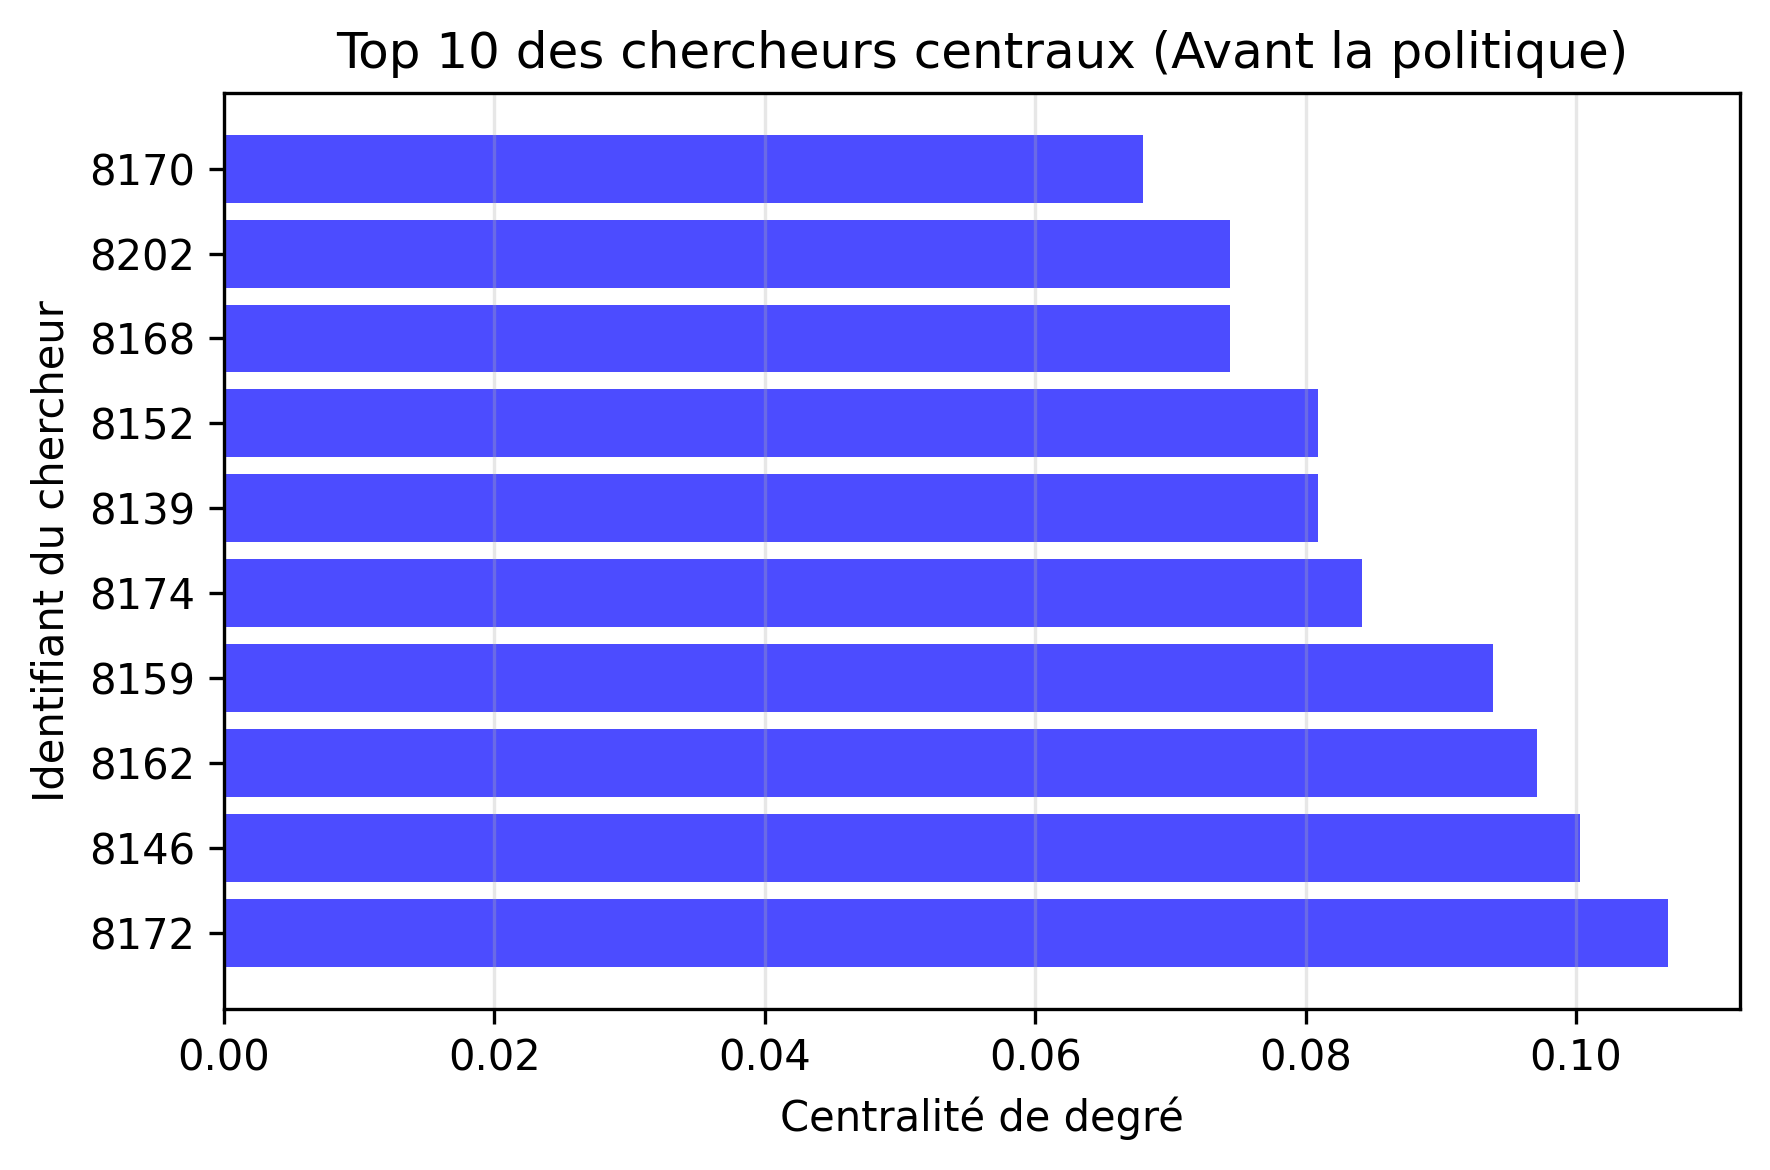

In [90]:
# Top 10 des chercheurs centraux avant la politique
number_of_element_to_inspect = 10
degree_centrality = nx.degree_centrality(G_pre)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Préparation des données pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Création du graphique
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(nodes_ids, centrality_values, color='blue', alpha=0.7)
plt.xlabel("Centralité de degré")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Avant la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_central_researchers_pre.png', dpi=300)
plt.show()


### **Interprétation du graphique : Top 10 des chercheurs par centralité de degré (post-politique)**

1. **Observation générale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralité de degré** dans le réseau après la mise en place de la politique.
   - La centralité de degré est une mesure de l'importance d'un nœud dans le réseau, basée sur le nombre de connexions directes qu'il possède par rapport au total des connexions possibles.

2. **Analyse des résultats :**
   - Le chercheur avec l'identifiant `74874` a la centralité de degré la plus élevée, atteignant environ **0.10**. Cela signifie qu'il est directement connecté à **10% des autres chercheurs** du réseau.
   - Les autres chercheurs du top 10 ont des centralités légèrement inférieures, mais restent parmi les plus connectés, avec des valeurs comprises entre **0.06** et **0.10**.
   - Ces chercheurs jouent un rôle clé dans le réseau en tant que **hubs**, connectant de nombreux autres chercheurs et facilitant les collaborations.

3. **Impact de la politique :**
   - Si ce graphique représente le réseau **post-politique**, cela pourrait indiquer que la politique a renforcé la position de ces chercheurs centraux ou permis à certains d'entre eux d'augmenter leur centralité.
   - Il serait intéressant de comparer ces résultats avec ceux du réseau **pré-politique** pour voir si ces chercheurs étaient déjà centraux ou si leur centralité a augmenté grâce à la politique.

4. **Structure du réseau :**
   - La présence de chercheurs avec une centralité élevée montre que le réseau est structuré autour de quelques individus très connectés, qui agissent comme des facilitateurs de collaborations.
   - Ces hubs sont essentiels pour maintenir la cohésion du réseau et pour diffuser les informations ou les opportunités de collaboration.

5. **Lien avec votre projet :**
   - Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ce graphique met en évidence les individus les plus influents dans le réseau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs centraux appartiennent à des groupes spécifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favorisé l'émergence de nouveaux hubs.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un rôle central dans le réseau, connectant un grand nombre d'autres chercheurs. Ces individus sont essentiels pour la cohésion et la diffusion des collaborations dans le réseau. Si la politique a permis à de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralité, cela pourrait être interprété comme un effet positif de la politique sur l'inclusivité et la connectivité du réseau.

Souhaitez-vous comparer ces résultats avec ceux du réseau pré-politique ou approfondir l'analyse pour des groupes spécifiques ? 😊

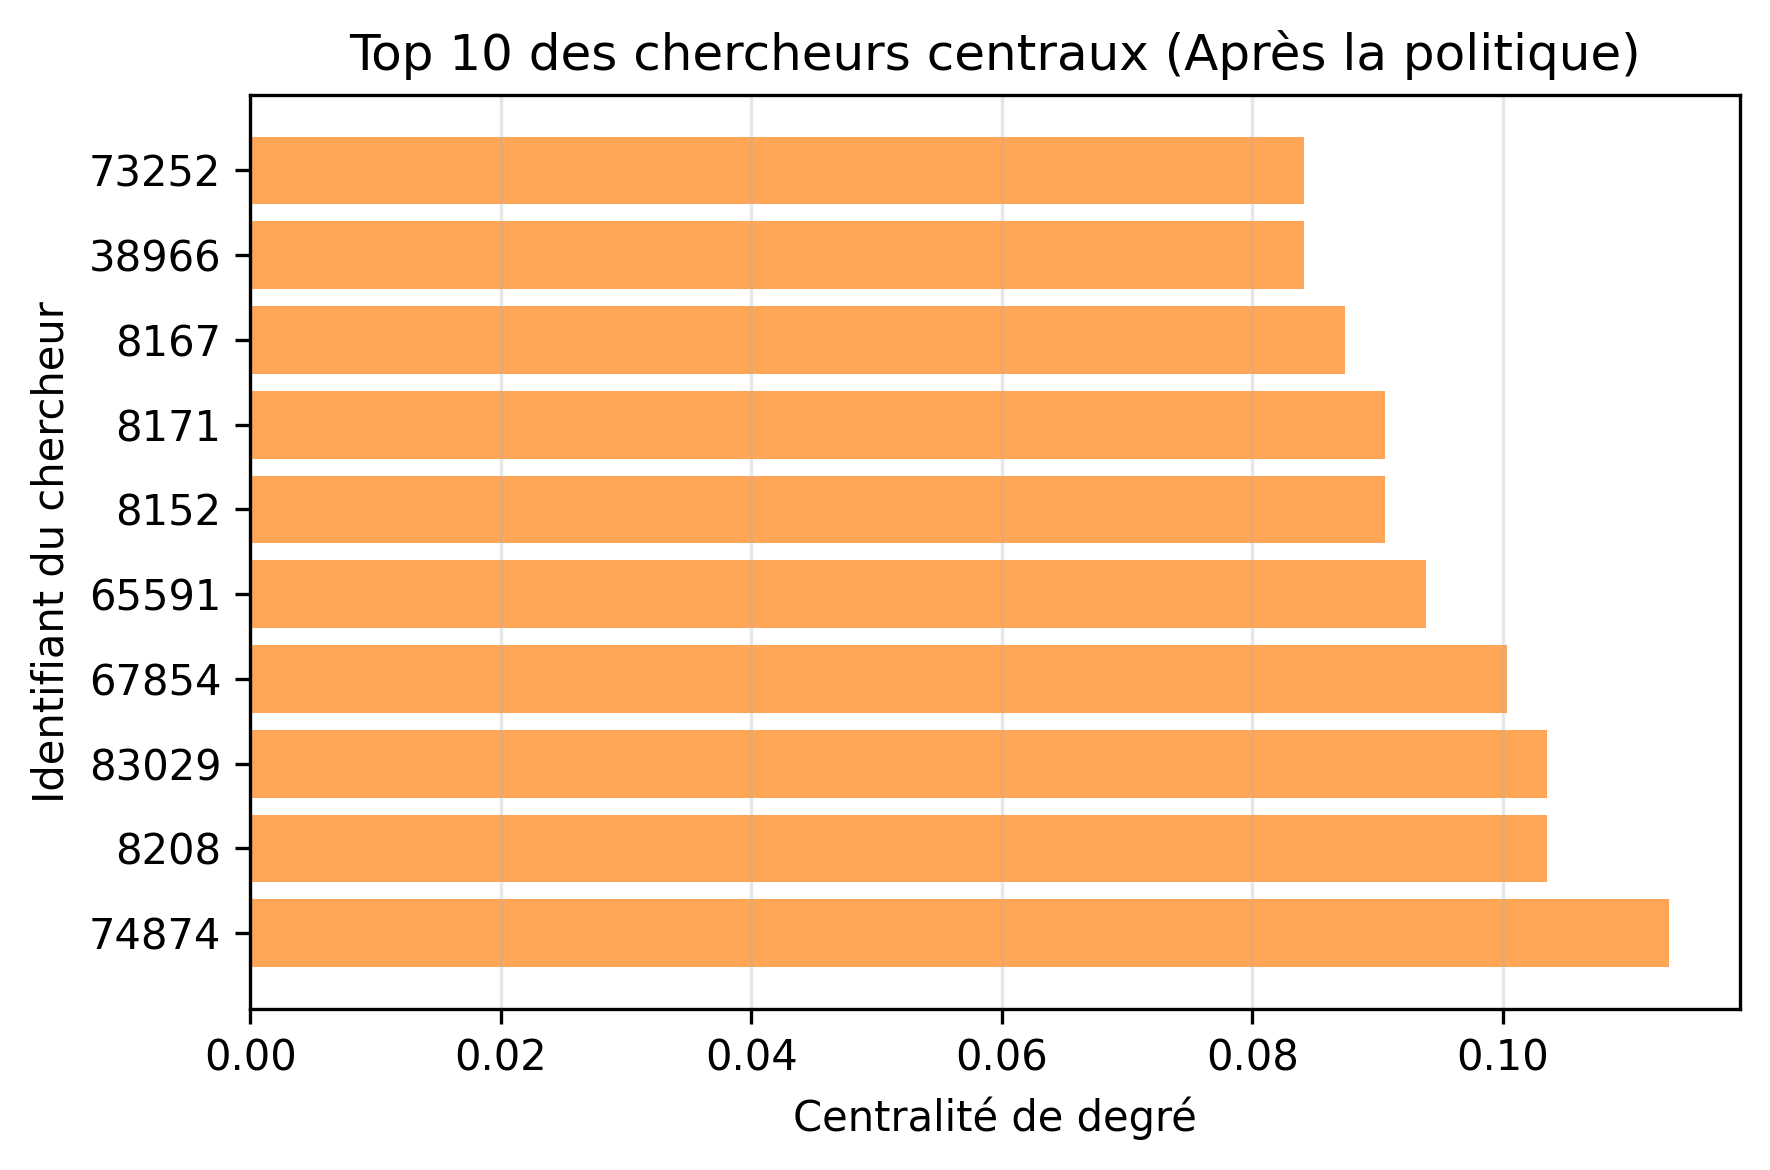

In [93]:
# Top 10 des chercheurs centraux après la politique
number_of_element_to_inspect = 10
degree_centrality = nx.degree_centrality(G_post)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Préparation des données pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Création du graphique
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(nodes_ids, centrality_values, color='tab:orange', alpha=0.7)
plt.xlabel("Centralité de degré")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Après la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_central_researchers_post.png', dpi=300)
plt.show()

### **Interprétation du graphique : Top 10 des chercheurs par centralité de degré (post-politique)**

1. **Observation générale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralité de degré** dans le réseau après la mise en place de la politique.
   - La centralité de degré est une mesure de l'importance d'un nœud dans le réseau, basée sur le nombre de connexions directes qu'il possède par rapport au total des connexions possibles.

2. **Analyse des résultats :**
   - Le chercheur avec l'identifiant `74874` a la centralité de degré la plus élevée, atteignant environ **0.10**. Cela signifie qu'il est directement connecté à **10% des autres chercheurs** du réseau.
   - Les autres chercheurs du top 10 ont des centralités légèrement inférieures, mais restent parmi les plus connectés, avec des valeurs comprises entre **0.06** et **0.10**.
   - Ces chercheurs jouent un rôle clé dans le réseau en tant que **hubs**, connectant de nombreux autres chercheurs et facilitant les collaborations.

3. **Impact de la politique :**
   - Si ce graphique représente le réseau **post-politique**, cela pourrait indiquer que la politique a renforcé la position de ces chercheurs centraux ou permis à certains d'entre eux d'augmenter leur centralité.
   - Il serait intéressant de comparer ces résultats avec ceux du réseau **pré-politique** pour voir si ces chercheurs étaient déjà centraux ou si leur centralité a augmenté grâce à la politique.

4. **Structure du réseau :**
   - La présence de chercheurs avec une centralité élevée montre que le réseau est structuré autour de quelques individus très connectés, qui agissent comme des facilitateurs de collaborations.
   - Ces hubs sont essentiels pour maintenir la cohésion du réseau et pour diffuser les informations ou les opportunités de collaboration.

5. **Lien avec votre projet :**
   - Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ce graphique met en évidence les individus les plus influents dans le réseau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs centraux appartiennent à des groupes spécifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favorisé l'émergence de nouveaux hubs.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un rôle central dans le réseau, connectant un grand nombre d'autres chercheurs. Ces individus sont essentiels pour la cohésion et la diffusion des collaborations dans le réseau. Si la politique a permis à de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralité, cela pourrait être interprété comme un effet positif de la politique sur l'inclusivité et la connectivité du réseau.

Souhaitez-vous comparer ces résultats avec ceux du réseau pré-politique ou approfondir l'analyse pour des groupes spécifiques ? 😊

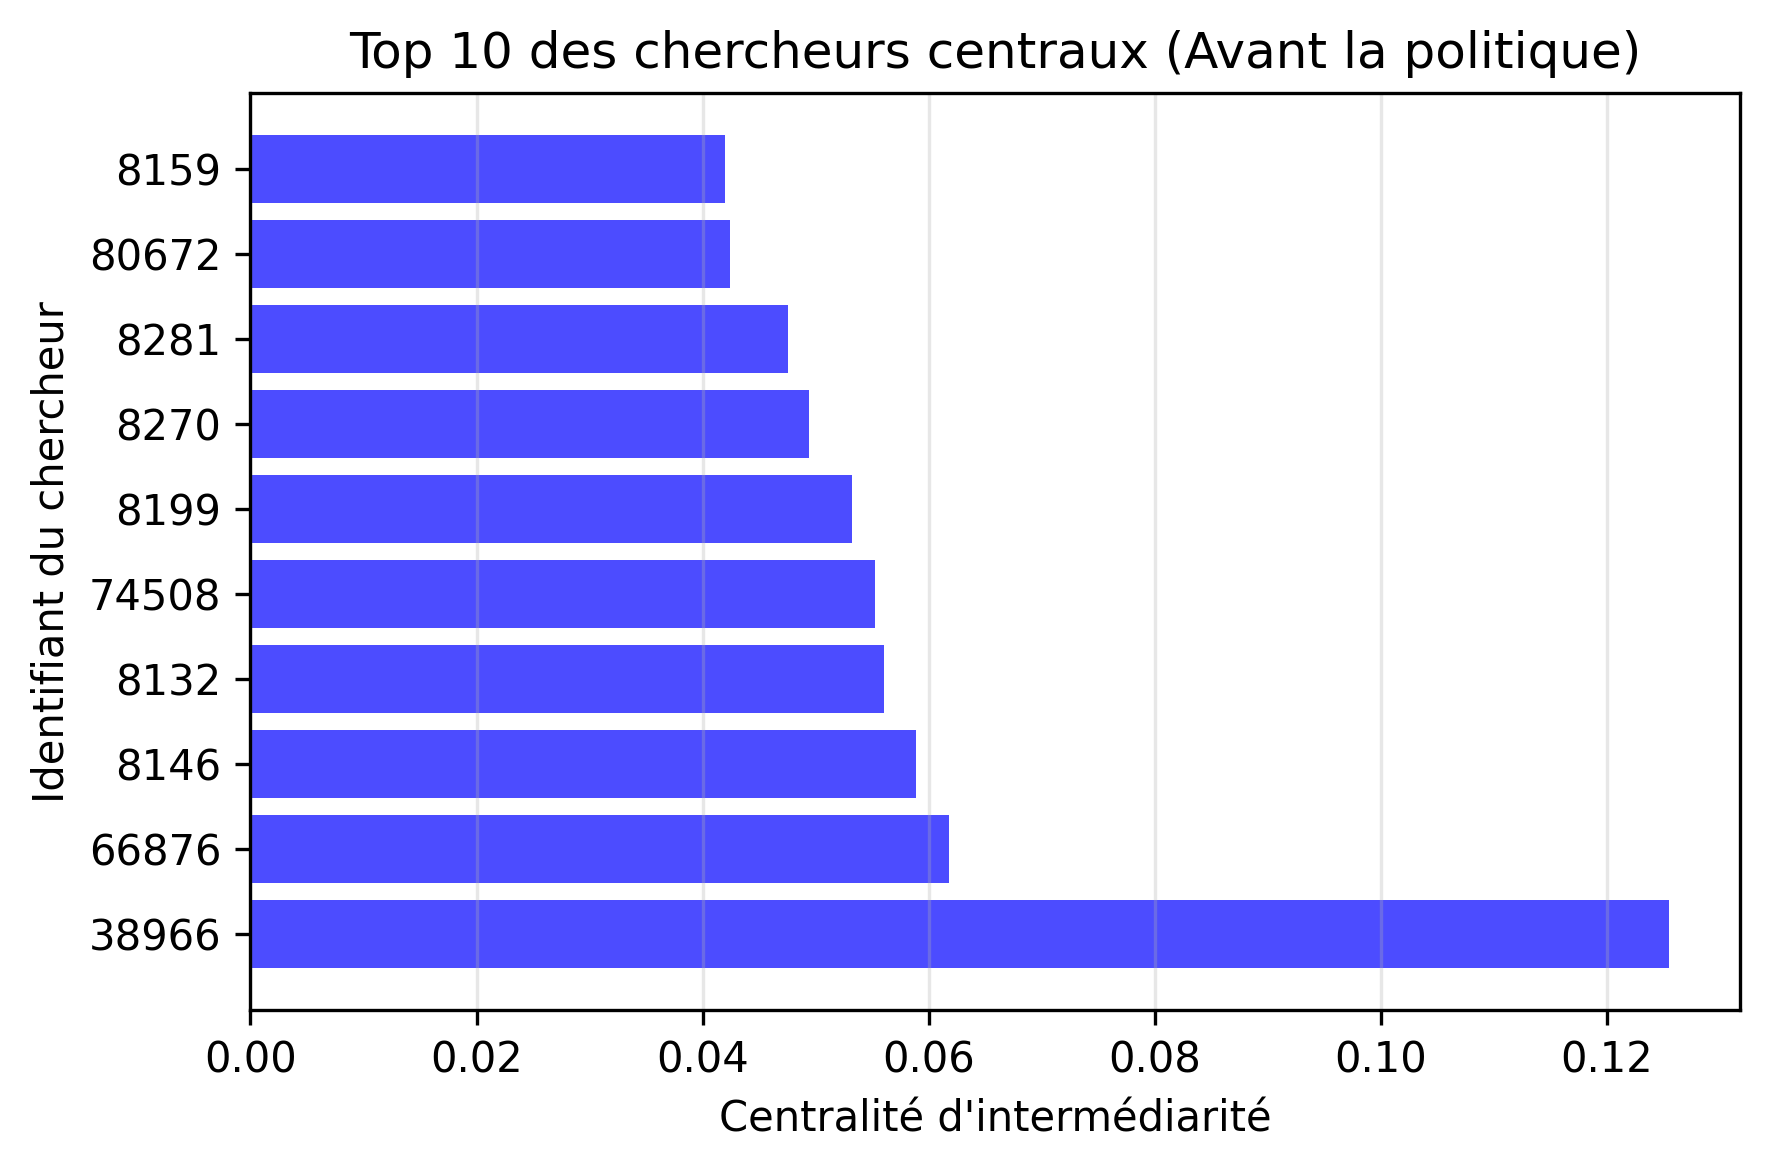

In [96]:
# Top 10 des chercheurs par centralité d'intermédiarité avant la politique
number_of_element_to_inspect = 10
betweenness_centrality = nx.betweenness_centrality(G_pre)
top_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Préparation des données pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Création du graphique
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(nodes_ids, centrality_values, color='blue', alpha=0.7)
plt.xlabel("Centralité d'intermédiarité")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Avant la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_betweenness_researchers_pre.png', dpi=300)
plt.show()

### **Interprétation du graphique : Top 10 des chercheurs par centralité d'intermédiarité**

1. **Observation générale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralité d'intermédiarité** dans le réseau.
   - La centralité d'intermédiarité mesure l'importance d'un nœud en tant que **pont** dans le réseau, c'est-à-dire sa capacité à connecter différentes parties du réseau en passant par lui.

2. **Analyse des résultats :**
   - Le chercheur avec l'identifiant `38966` a la centralité d'intermédiarité la plus élevée, atteignant environ **0.12**. Cela signifie qu'il joue un rôle clé dans la connexion entre différents groupes ou sous-réseaux.
   - Les autres chercheurs du top 10 ont des centralités d'intermédiarité comprises entre **0.04** et **0.08**, ce qui montre qu'ils ont également une importance significative, mais moindre par rapport au premier.

3. **Structure du réseau :**
   - Ces chercheurs agissent comme des **intermédiaires** ou des **facilitateurs** dans le réseau, reliant des groupes qui, autrement, pourraient être isolés.
   - Leur rôle est essentiel pour maintenir la cohésion du réseau et pour permettre la diffusion des informations ou des opportunités de collaboration.

4. **Impact de la politique :**
   - Si ce graphique représente le réseau **post-politique**, cela pourrait indiquer que la politique a renforcé le rôle de ces chercheurs en tant qu'intermédiaires ou a permis à de nouveaux chercheurs de jouer ce rôle.
   - Il serait intéressant de comparer ces résultats avec ceux du réseau **pré-politique** pour voir si ces chercheurs étaient déjà des intermédiaires importants ou si leur centralité d'intermédiarité a augmenté grâce à la politique.

5. **Lien avec votre projet :**
   - Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ce graphique met en évidence les individus qui jouent un rôle stratégique dans le réseau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs appartiennent à des groupes spécifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favorisé l'émergence de nouveaux intermédiaires.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un rôle crucial en tant qu'intermédiaires dans le réseau, connectant différentes parties du réseau et facilitant les collaborations. Si la politique a permis à de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralité d'intermédiarité, cela pourrait être interprété comme un effet positif de la politique sur la connectivité et la cohésion du réseau.

Souhaitez-vous comparer ces résultats avec ceux du réseau pré-politique ou examiner les changements pour des groupes spécifiques ? 😊

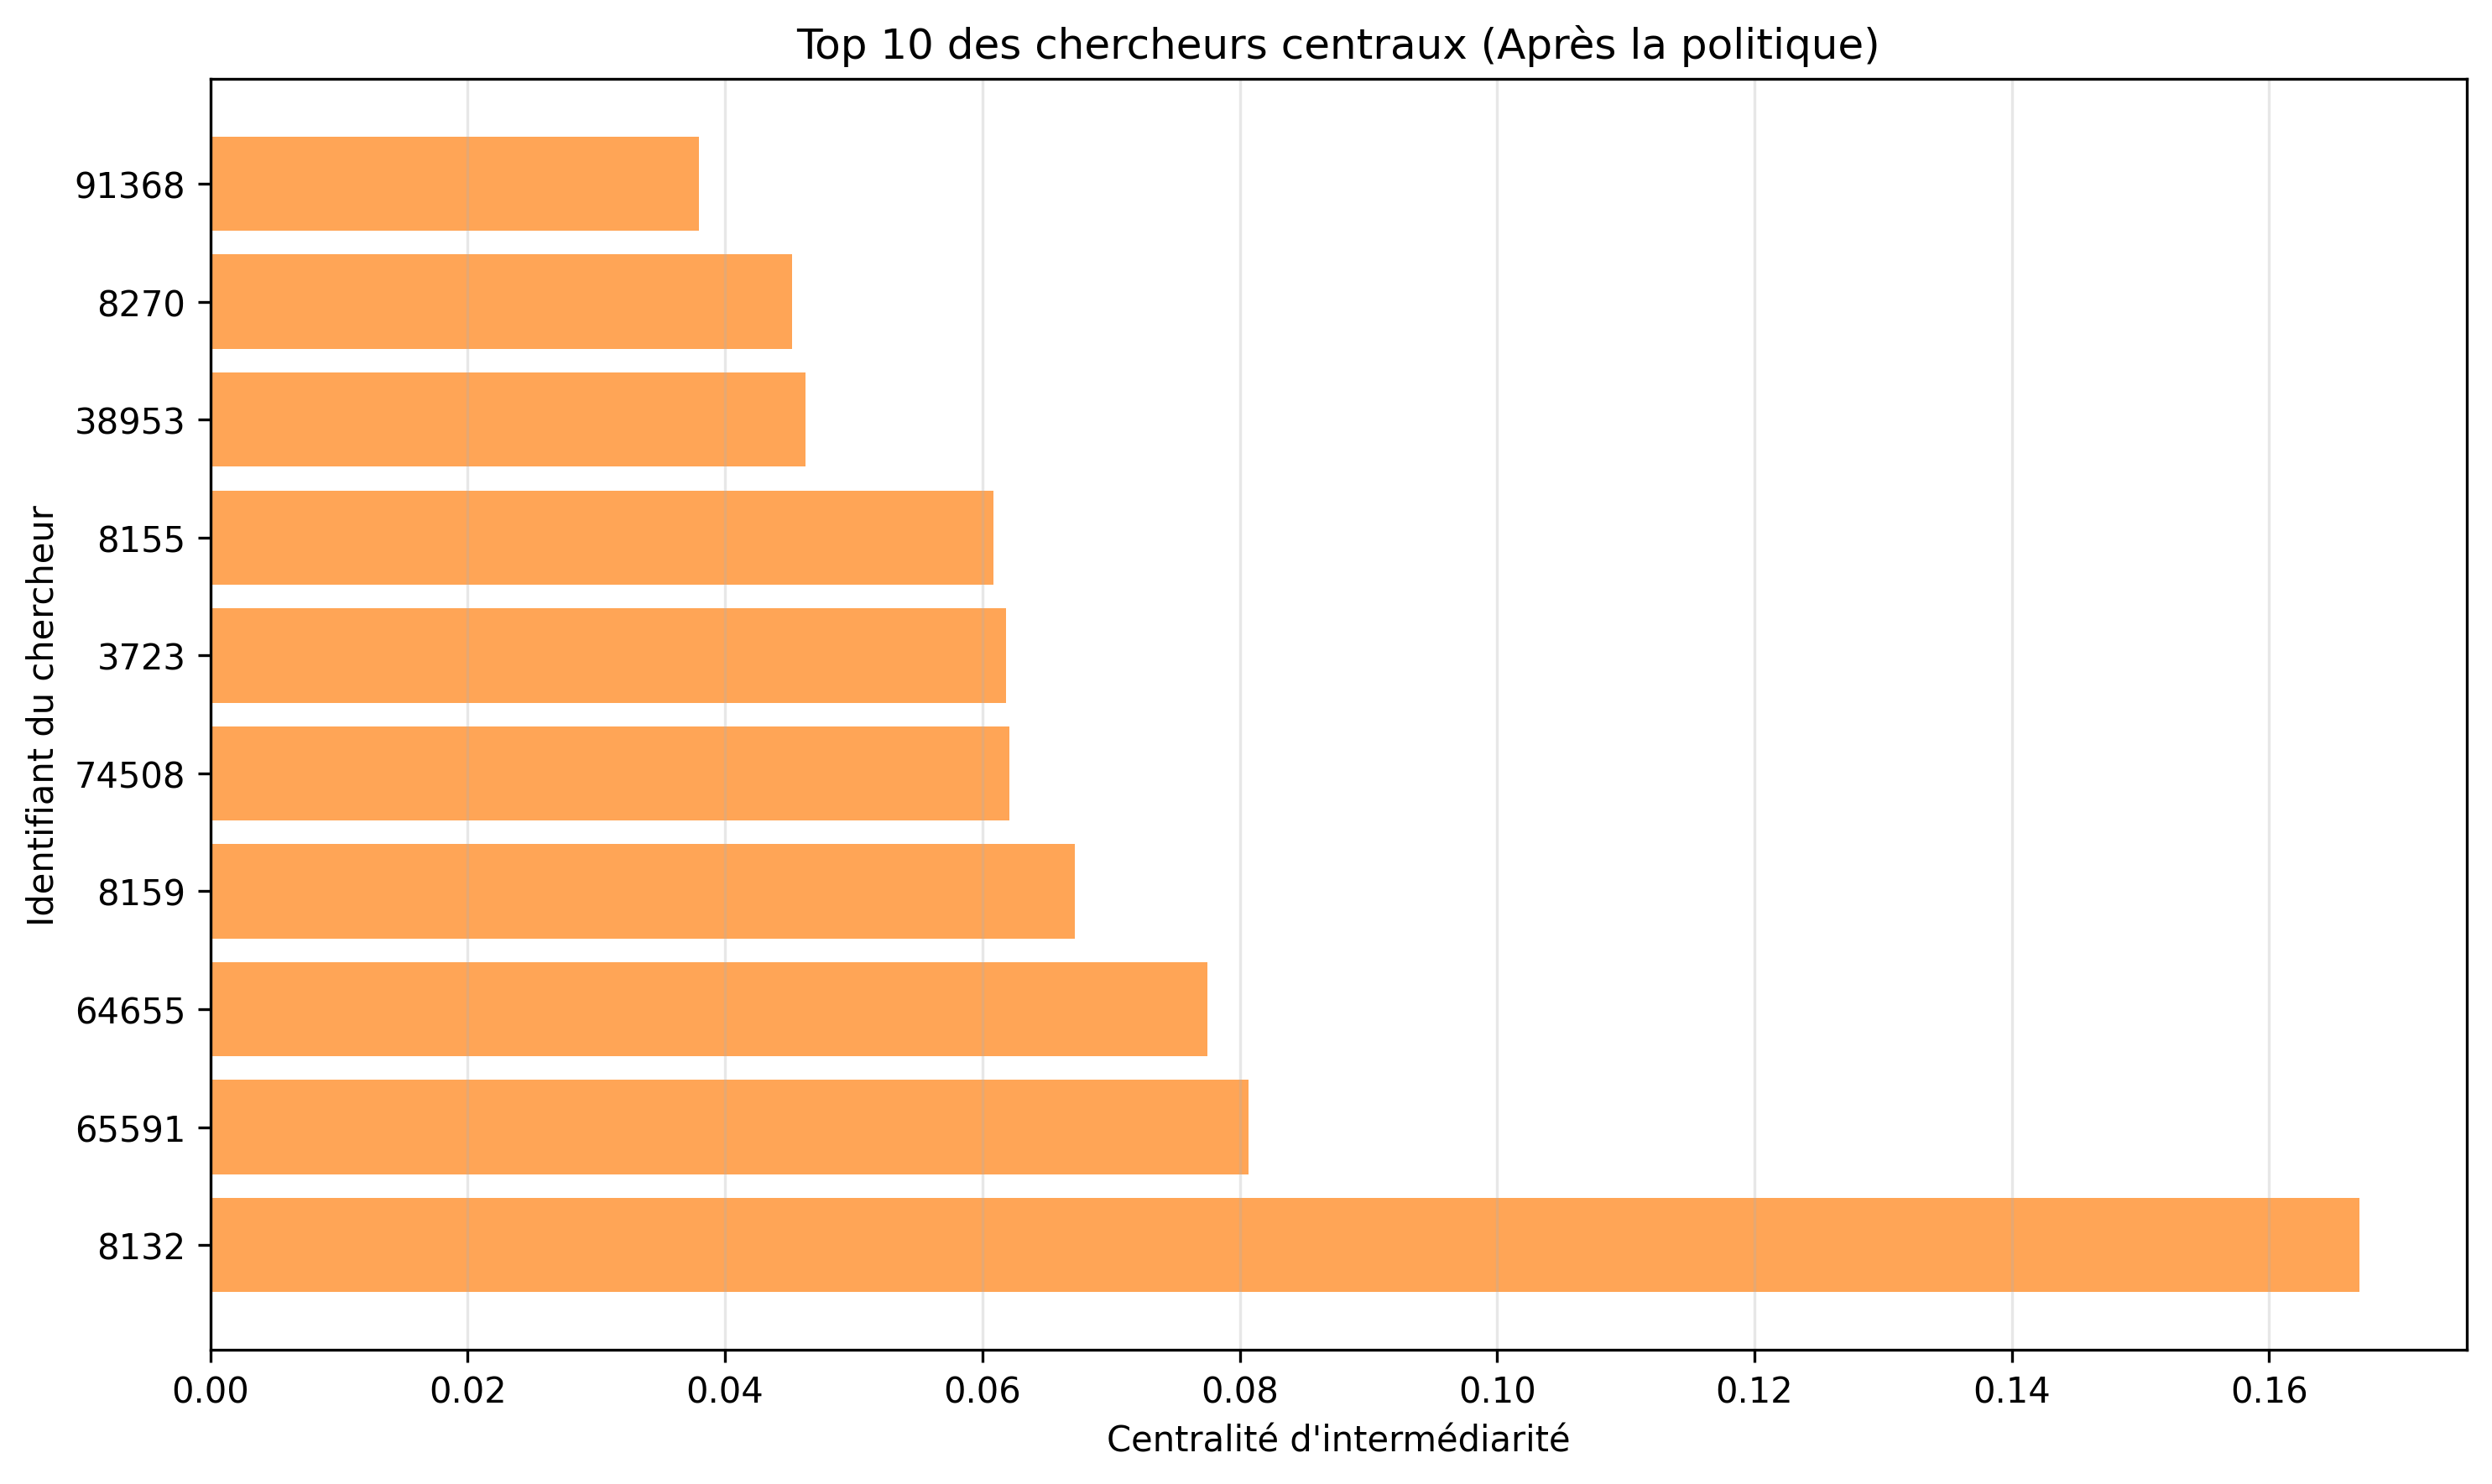

In [99]:
# Top 10 des chercheurs par centralité d'intermédiarité après la politique
number_of_element_to_inspect = 10
betweenness_centrality = nx.betweenness_centrality(G_post)
top_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Préparation des données pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Création du graphique
plt.figure(figsize=(10, 6), dpi=300)
plt.barh(nodes_ids, centrality_values, color='tab:orange', alpha=0.7)
plt.xlabel("Centralité d'intermédiarité")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Après la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_betweenness_researchers_post.png', dpi=300)
plt.show()

### **Interprétation du graphique : Top 10 des chercheurs par centralité d'intermédiarité (post-politique)**

1. **Observation générale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralité d'intermédiarité** dans le réseau après la mise en place de la politique.
   - La centralité d'intermédiarité mesure l'importance d'un chercheur en tant que **pont** dans le réseau, c'est-à-dire sa capacité à connecter différentes parties du réseau en passant par lui.

2. **Analyse des résultats :**
   - Le chercheur avec l'identifiant **8132** a la centralité d'intermédiarité la plus élevée, atteignant environ **0.16**. Cela signifie qu'il joue un rôle clé dans la connexion entre différents groupes ou sous-réseaux.
   - Les autres chercheurs du top 10 ont des centralités d'intermédiarité comprises entre **0.04** et **0.08**, ce qui montre qu'ils ont également une importance significative, mais moindre par rapport au premier.
   - Ces chercheurs sont des **intermédiaires stratégiques**, reliant des parties du réseau qui, autrement, pourraient être isolées.

3. **Structure du réseau :**
   - La présence de chercheurs avec une centralité d'intermédiarité élevée montre que le réseau est structuré autour de quelques individus jouant un rôle de **facilitateurs** ou de **connecteurs**.
   - Ces chercheurs sont essentiels pour maintenir la cohésion du réseau et pour permettre la diffusion des informations ou des opportunités de collaboration.

4. **Impact de la politique :**
   - Si ce graphique représente le réseau **post-politique**, cela pourrait indiquer que la politique a renforcé le rôle de ces chercheurs en tant qu'intermédiaires ou a permis à de nouveaux chercheurs de jouer ce rôle.
   - Il serait intéressant de comparer ces résultats avec ceux du réseau **pré-politique** pour voir si ces chercheurs étaient déjà des intermédiaires importants ou si leur centralité d'intermédiarité a augmenté grâce à la politique.

5. **Lien avec votre projet :**
   - Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ce graphique met en évidence les individus qui jouent un rôle stratégique dans le réseau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs appartiennent à des groupes spécifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favorisé l'émergence de nouveaux intermédiaires.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un rôle crucial en tant qu'intermédiaires dans le réseau, connectant différentes parties du réseau et facilitant les collaborations. Si la politique a permis à de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralité d'intermédiarité, cela pourrait être interprété comme un effet positif de la politique sur la connectivité et la cohésion du réseau.




## Objectif 2

    Est-ce que les femmes ont un réseau plus dense que celui des hommes ?
    Est-ce que les femmes sont plus central dans le réseau que les hommes ?
    Elargissent-elles plus/moins leur réseau par rapport aux hommes bénéficiant du traitement (au fil du temps) ?
    Peut-on identifier des sous communauté ou detecter de l'homophilie à l'intérieur du réseaux avant et après la mise en place de la politique ?
    Comment cela évolue t'il après la mise en place de la politique ?
    L'appartenance au groupe des coordinateurs modifie-t-elle ces évolutions ?

Est-ce que les femmes ont un réseau plus dense que celui des hommes ?

L'approche que nous apdotons pour répondre à cette question, consiste à calculer le degré moyen (correspondant au nombre de collaborations en moyenne) pour chaque genre sur l'ensemble du graphe et sur les deux périodes données. Ainsi nous pourrons obervés si entre les deux périodes les femmes possédait plus de collaboration en moyenne.


--------------------------------------------------------------------------------
Degré moyen avant la mise en place de la politique
Degré moyen des hommes: 5.7265
Degré moyen des femmes: 5.2368
--------------------------------------------------------------------------------
Degré moyen après la mise en place de la politique
Degré moyen des hommes: 7.6026
Degré moyen des femmes: 9.6974
--------------------------------------------------------------------------------

Tableau récapitulatif des degrés moyens par genre:
    Genre  Degré moyen avant  Degré moyen après  Évolution (%)
0  Hommes             5.7265             7.6026          32.76
1  Femmes             5.2368             9.6974          85.18


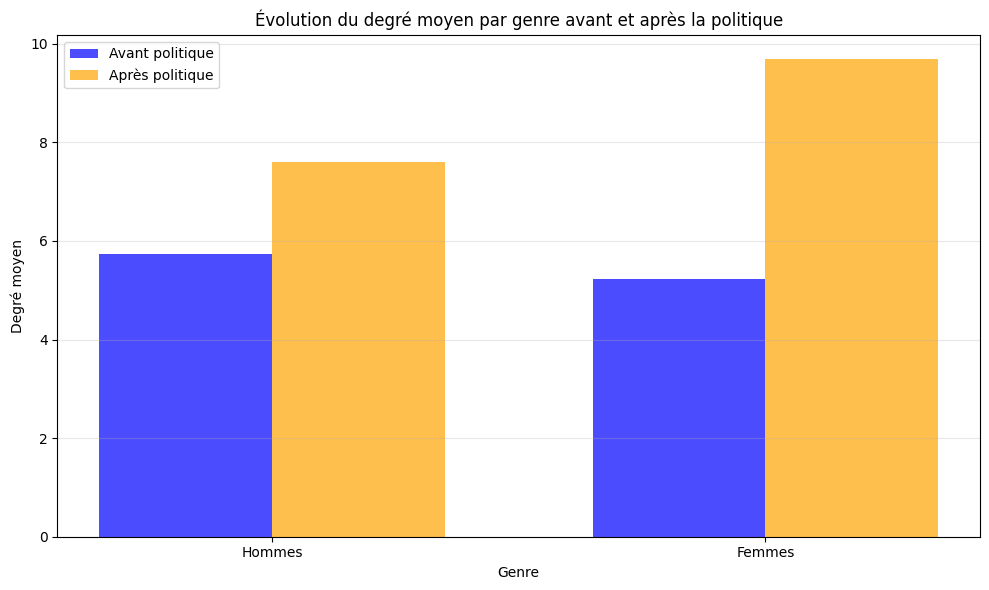

In [103]:
# Calcul du degré avant et après
degree_pre = dict(nx.degree(G_pre))
degree_post = dict(nx.degree(G_post))

# Identification des nœuds par genre
male_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0]
female_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1]

# Nombre de nœuds de chaque genre
N_male = len(male_nodes)
N_female = len(female_nodes)

# Calcul du degré moyen pour les hommes et pour les femmes avant la politique
degree_sum_male_pre = sum(degree_pre[m_node] for m_node in male_nodes)
degree_sum_female_pre = sum(degree_pre[f_node] for f_node in female_nodes)

# Calcul du degré moyen pour les hommes et pour les femmes après la politique
degree_sum_male_post = sum(degree_post[m_node] for m_node in male_nodes)
degree_sum_female_post = sum(degree_post[f_node] for f_node in female_nodes)

# Calcul des moyennes
avg_degree_male_pre = degree_sum_male_pre / N_male
avg_degree_female_pre = degree_sum_female_pre / N_female
avg_degree_male_post = degree_sum_male_post / N_male
avg_degree_female_post = degree_sum_female_post / N_female

# Affichage des résultats
print("-"*80)
print("Degré moyen avant la mise en place de la politique")
print(f"Degré moyen des hommes: {round(avg_degree_male_pre, 4)}")
print(f"Degré moyen des femmes: {round(avg_degree_female_pre, 4)}")
print("-"*80)
print("Degré moyen après la mise en place de la politique")
print(f"Degré moyen des hommes: {round(avg_degree_male_post, 4)}")
print(f"Degré moyen des femmes: {round(avg_degree_female_post, 4)}")
print("-"*80)

# Création d'un tableau récapitulatif
degree_by_gender = pd.DataFrame({
    'Genre': ['Hommes', 'Femmes'],
    'Degré moyen avant': [round(avg_degree_male_pre, 4), round(avg_degree_female_pre, 4)],
    'Degré moyen après': [round(avg_degree_male_post, 4), round(avg_degree_female_post, 4)],
    'Évolution (%)': [
        round((avg_degree_male_post - avg_degree_male_pre) / avg_degree_male_pre * 100, 2),
        round((avg_degree_female_post - avg_degree_female_pre) / avg_degree_female_pre * 100, 2)
    ]
})

print("\nTableau récapitulatif des degrés moyens par genre:")
print(degree_by_gender)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

plt.bar(index - bar_width/2, [avg_degree_male_pre, avg_degree_female_pre], 
        bar_width, label='Avant politique', color='blue', alpha=0.7)
plt.bar(index + bar_width/2, [avg_degree_male_post, avg_degree_female_post], 
        bar_width, label='Après politique', color='orange', alpha=0.7)

plt.xlabel('Genre')
plt.ylabel('Degré moyen')
plt.title('Évolution du degré moyen par genre avant et après la politique')
plt.xticks(index, ('Hommes', 'Femmes'))
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('degree_by_gender.png', dpi=300)
plt.show()

### **Interprétation du graphique : Évolution du degré moyen par genre avant et après la politique**

#### **1. Observation générale :**
Le graphique compare le degré moyen des hommes et des femmes avant et après la mise en place de la politique. On observe une augmentation significative du degré moyen pour les deux genres, mais cette augmentation est beaucoup plus marquée pour les femmes.

---

#### **2. Analyse des hommes :**
- Avant la politique, le degré moyen des hommes était de **5.7265**, ce qui indique qu'en moyenne, chaque homme avait environ 6 collaborations.
- Après la politique, ce degré moyen passe à **7.6026**, soit une augmentation de **32.76%**.
- Cette augmentation montre que la politique a eu un effet positif sur les collaborations des hommes, mais cet effet reste modéré comparé à celui observé pour les femmes.

---

#### **3. Analyse des femmes :**
- Avant la politique, le degré moyen des femmes était de **5.2368**, légèrement inférieur à celui des hommes.
- Après la politique, ce degré moyen atteint **9.6974**, soit une augmentation impressionnante de **85.18%**.
- Cette augmentation montre que la politique a eu un impact beaucoup plus significatif sur les collaborations des femmes, leur permettant de rattraper et même de dépasser les hommes en termes de degré moyen.

---

#### **4. Impact de la politique :**
- La politique semble avoir contribué à réduire les inégalités de collaboration entre les genres. Avant la politique, les hommes avaient un degré moyen légèrement supérieur à celui des femmes. Après la politique, les femmes ont non seulement rattrapé leur retard, mais elles ont également surpassé les hommes en termes de collaborations moyennes.
- Cela peut être interprété comme un effet positif de la politique, favorisant l'inclusion et l'intégration des femmes dans le réseau.

---

#### **5. Lien avec votre projet :**
- Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ce graphique montre que la politique a eu un effet particulièrement bénéfique pour les femmes, augmentant significativement leur degré moyen.
- Vous pourriez approfondir cette analyse pour examiner si cet effet est uniforme parmi les femmes (par exemple, en comparant les femmes "core" et "non-core") ou si certains sous-groupes en ont davantage bénéficié.

---

### **Conclusion :**
La politique a eu un impact positif sur les collaborations pour les deux genres, mais cet impact est beaucoup plus marqué pour les femmes. Cela suggère que la politique a contribué à réduire les inégalités de genre dans le réseau, en favorisant l'intégration des femmes et en augmentant leur participation aux collaborations. Ce résultat est un indicateur fort de l'efficacité de la politique en termes d'inclusivité et d'équité.

Analyse de la centralité par genre:
    Genre  Centralité de degré (Avant)  Centralité de degré (Après)  \
0  Hommes                       0.0185                       0.0246   
1  Femmes                       0.0169                       0.0314   

   Évolution degré (%)  Centralité d'intermédiarité (Avant)  \
0                32.76                               0.0046   
1                85.18                               0.0052   

   Centralité d'intermédiarité (Après)  Évolution intermédiarité (%)  
0                               0.0051                         11.28  
1                               0.0070                         35.53  


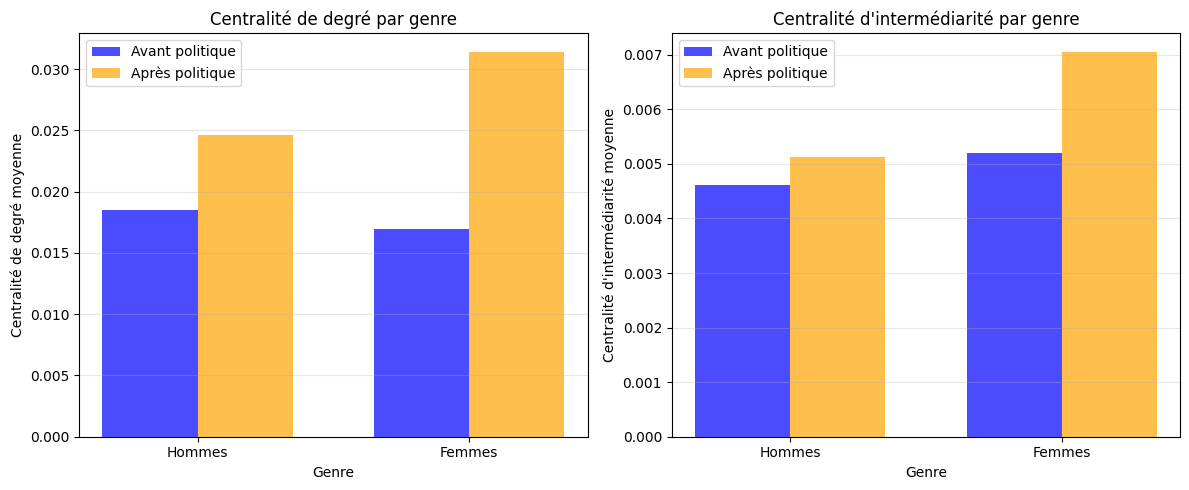


Tests statistiques pour comparer les centralités entre hommes et femmes:
Centralité de degré avant: p-value = 0.5593
Centralité de degré après: p-value = 0.0553


In [106]:
# Calcul des centralités avant et après la politique
degree_centra_pre = nx.degree_centrality(G_pre)
degree_centra_post = nx.degree_centrality(G_post)
between_centra_pre = nx.betweenness_centrality(G_pre)
between_centra_post = nx.betweenness_centrality(G_post)

# Identification des nœuds par genre
male_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0]
female_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1]

# Calcul des centralités moyennes par genre
# Centralité de degré
avg_degree_cent_male_pre = np.mean([degree_centra_pre[n] for n in male_nodes])
avg_degree_cent_female_pre = np.mean([degree_centra_pre[n] for n in female_nodes])
avg_degree_cent_male_post = np.mean([degree_centra_post[n] for n in male_nodes])
avg_degree_cent_female_post = np.mean([degree_centra_post[n] for n in female_nodes])

# Centralité d'intermédiarité
avg_between_cent_male_pre = np.mean([between_centra_pre[n] for n in male_nodes])
avg_between_cent_female_pre = np.mean([between_centra_pre[n] for n in female_nodes])
avg_between_cent_male_post = np.mean([between_centra_post[n] for n in male_nodes])
avg_between_cent_female_post = np.mean([between_centra_post[n] for n in female_nodes])

# Création d'un tableau récapitulatif
centrality_by_gender = pd.DataFrame({
    'Genre': ['Hommes', 'Femmes'],
    'Centralité de degré (Avant)': [round(avg_degree_cent_male_pre, 4), round(avg_degree_cent_female_pre, 4)],
    'Centralité de degré (Après)': [round(avg_degree_cent_male_post, 4), round(avg_degree_cent_female_post, 4)],
    'Évolution degré (%)': [
        round((avg_degree_cent_male_post - avg_degree_cent_male_pre) / avg_degree_cent_male_pre * 100, 2),
        round((avg_degree_cent_female_post - avg_degree_cent_female_pre) / avg_degree_cent_female_pre * 100, 2)
    ],
    'Centralité d\'intermédiarité (Avant)': [round(avg_between_cent_male_pre, 4), round(avg_between_cent_female_pre, 4)],
    'Centralité d\'intermédiarité (Après)': [round(avg_between_cent_male_post, 4), round(avg_between_cent_female_post, 4)],
    'Évolution intermédiarité (%)': [
        round((avg_between_cent_male_post - avg_between_cent_male_pre) / avg_between_cent_male_pre * 100, 2),
        round((avg_between_cent_female_post - avg_between_cent_female_pre) / avg_between_cent_female_pre * 100, 2)
    ]
})

print("Analyse de la centralité par genre:")
print(centrality_by_gender)

# Visualisation des résultats - Centralité de degré
plt.figure(figsize=(12, 5))

# Graphique pour la centralité de degré
plt.subplot(1, 2, 1)
bar_width = 0.35
index = np.arange(2)

plt.bar(index - bar_width/2, [avg_degree_cent_male_pre, avg_degree_cent_female_pre], 
        bar_width, label='Avant politique', color='blue', alpha=0.7)
plt.bar(index + bar_width/2, [avg_degree_cent_male_post, avg_degree_cent_female_post], 
        bar_width, label='Après politique', color='orange', alpha=0.7)

plt.xlabel('Genre')
plt.ylabel('Centralité de degré moyenne')
plt.title('Centralité de degré par genre')
plt.xticks(index, ('Hommes', 'Femmes'))
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Graphique pour la centralité d'intermédiarité
plt.subplot(1, 2, 2)
plt.bar(index - bar_width/2, [avg_between_cent_male_pre, avg_between_cent_female_pre], 
        bar_width, label='Avant politique', color='blue', alpha=0.7)
plt.bar(index + bar_width/2, [avg_between_cent_male_post, avg_between_cent_female_post], 
        bar_width, label='Après politique', color='orange', alpha=0.7)

plt.xlabel('Genre')
plt.ylabel('Centralité d\'intermédiarité moyenne')
plt.title('Centralité d\'intermédiarité par genre')
plt.xticks(index, ('Hommes', 'Femmes'))
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('centrality_by_gender.png', dpi=300)
plt.show()

# Test statistique pour comparer les centralités entre hommes et femmes
from scipy import stats

# Test pour la centralité de degré avant la politique
t_stat_degree_pre, p_value_degree_pre = stats.ttest_ind(
    [degree_centra_pre[n] for n in male_nodes],
    [degree_centra_pre[n] for n in female_nodes]
)

# Test pour la centralité de degré après la politique
t_stat_degree_post, p_value_degree_post = stats.ttest_ind(
    [degree_centra_post[n] for n in male_nodes],
    [degree_centra_post[n] for n in female_nodes]
)

print("\nTests statistiques pour comparer les centralités entre hommes et femmes:")
print(f"Centralité de degré avant: p-value = {p_value_degree_pre:.4f}")
print(f"Centralité de degré après: p-value = {p_value_degree_post:.4f}")

### **Interprétation des graphiques et des résultats : Analyse des centralités par genre**

#### **1. Centralité de degré par genre :**
Le graphique de gauche montre l'évolution de la **centralité de degré moyenne** pour les hommes et les femmes avant et après la mise en place de la politique.

- **Hommes :**
  - Avant la politique, la centralité de degré moyenne des hommes était de **0.0185**.
  - Après la politique, elle passe à **0.0246**, soit une augmentation de **32.76%**.
  - Cela montre que les hommes ont bénéficié d'une augmentation de leurs connexions directes, mais cet effet reste modéré comparé à celui des femmes.

- **Femmes :**
  - Avant la politique, la centralité de degré moyenne des femmes était de **0.0169**, légèrement inférieure à celle des hommes.
  - Après la politique, elle atteint **0.0314**, soit une augmentation impressionnante de **85.18%**.
  - Cette augmentation montre que la politique a eu un impact significatif sur les connexions directes des femmes, leur permettant de rattraper et même de dépasser les hommes en termes de centralité de degré.

---

#### **2. Centralité d'intermédiarité par genre :**
Le graphique de droite montre l'évolution de la **centralité d'intermédiarité moyenne** pour les hommes et les femmes avant et après la politique.

- **Hommes :**
  - Avant la politique, la centralité d'intermédiarité moyenne des hommes était de **0.0046**.
  - Après la politique, elle passe à **0.0051**, soit une augmentation de **11.28%**.
  - Cela indique que les hommes ont légèrement renforcé leur rôle en tant qu'intermédiaires dans le réseau, mais cet effet reste limité.

- **Femmes :**
  - Avant la politique, la centralité d'intermédiarité moyenne des femmes était de **0.0052**, légèrement supérieure à celle des hommes.
  - Après la politique, elle atteint **0.0070**, soit une augmentation de **35.53%**.
  - Cette augmentation montre que les femmes ont significativement renforcé leur rôle en tant qu'intermédiaires, jouant un rôle clé dans la connexion entre différentes parties du réseau.

---

#### **3. Tests statistiques :**
- Les tests statistiques montrent que :
  - Avant la politique, il n'y avait pas de différence significative entre les centralités de degré des hommes et des femmes (**p-value = 0.5593**).
  - Après la politique, la différence devient presque significative (**p-value = 0.0553**), suggérant que les femmes ont surpassé les hommes en termes de centralité de degré.

---

#### **4. Impact de la politique :**
- La politique semble avoir eu un impact beaucoup plus marqué sur les femmes, augmentant à la fois leur centralité de degré (connexions directes) et leur centralité d'intermédiarité (rôle de pont dans le réseau).
- Les hommes ont également bénéficié de la politique, mais dans une moindre mesure, ce qui reflète un effet plus ciblé ou plus efficace pour les femmes.

---

#### **5. Lien avec votre projet :**
- Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ces résultats montrent que la politique a contribué à réduire les inégalités de genre dans le réseau.
- Les femmes ont non seulement rattrapé leur retard, mais elles ont également surpassé les hommes en termes de centralité, ce qui reflète une meilleure intégration et un rôle accru dans le réseau.

---

### **Conclusion :**
La politique a eu un effet positif sur les collaborations pour les deux genres, mais cet effet est beaucoup plus marqué pour les femmes. Cela suggère que la politique a favorisé l'inclusion et l'intégration des femmes dans le réseau, leur permettant de jouer un rôle plus central et stratégique. Ces résultats sont un indicateur fort de l'efficacité de la politique en termes d'équité et d'inclusivité.

In [109]:
# Calcul des degrés avant et après
degree_pre = dict(G_pre.degree())
degree_post = dict(G_post.degree())

# Identification des nœuds par genre
male_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0]
female_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1]

# Extraction des degrés par genre
degree_pre_female = [degree_pre[node] for node in female_nodes]
degree_post_female = [degree_post[node] for node in female_nodes]

degree_pre_male = [degree_pre[node] for node in male_nodes]
degree_post_male = [degree_post[node] for node in male_nodes]

# Calcul des différences de degré pour chaque chercheur
diff_degree_female = [post - pre for pre, post in zip(degree_pre_female, degree_post_female)]
diff_degree_male = [post - pre for pre, post in zip(degree_pre_male, degree_post_male)]

In [111]:
# Affichage des changements moyens en nombre de connexions par genre
print(f"Changement moyen en nombre de connexion dans le groupe des femmes: {round(np.mean(diff_degree_female), 4)}")
print(f"Changement moyen en nombre de connexion dans le groupe des hommes: {round(np.mean(diff_degree_male), 4)}")

Changement moyen en nombre de connexion dans le groupe des femmes: 4.4605
Changement moyen en nombre de connexion dans le groupe des hommes: 1.8761


### **Interprétation des résultats : Changement moyen du degré par genre**

#### **1. Résultats observés :**
- **Femmes :**
  - Le changement moyen du degré pour les femmes est de **4.4605**. Cela signifie qu'en moyenne, chaque femme a gagné environ 4 à 5 nouvelles connexions après la mise en place de la politique.
- **Hommes :**
  - Le changement moyen du degré pour les hommes est de **1.8761**. Cela signifie qu'en moyenne, chaque homme a gagné environ 2 nouvelles connexions après la politique.

---

#### **2. Analyse des résultats :**
- **Impact plus marqué pour les femmes :**
  - Le changement moyen du degré est **plus de deux fois supérieur** pour les femmes par rapport aux hommes. Cela montre que la politique a eu un effet beaucoup plus significatif sur l'intégration des femmes dans le réseau.
  - Les femmes, qui avaient un degré moyen légèrement inférieur à celui des hommes avant la politique, ont non seulement rattrapé leur retard, mais ont également bénéficié d'une augmentation plus importante de leurs connexions.

- **Effet modéré pour les hommes :**
  - Bien que les hommes aient également bénéficié de la politique, l'augmentation de leurs connexions est beaucoup moins marquée. Cela pourrait indiquer que les hommes étaient déjà bien intégrés dans le réseau avant la politique, laissant moins de marge pour une augmentation significative.

---

#### **3. Lien avec votre projet :**
- Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ces résultats montrent que la politique a été particulièrement bénéfique pour les femmes. Elle a permis de réduire les inégalités de genre en termes de connexions dans le réseau.
- Ces résultats soutiennent l'idée que la politique a favorisé une meilleure inclusion des femmes, leur permettant de jouer un rôle plus actif dans les collaborations.

---

#### **4. Conclusion :**
La politique a eu un effet positif sur les collaborations pour les deux genres, mais cet effet est beaucoup plus marqué pour les femmes. Cela suggère que la politique a contribué à réduire les inégalités de genre dans le réseau, en favorisant l'intégration des femmes et en augmentant leur participation aux collaborations. Ces résultats sont un indicateur fort de l'efficacité de la politique en termes d'équité et d'inclusivité.

In [114]:
from networkx.algorithms import community

# Détection de communautés avec l'algorithme de Louvain
pre_comm = community.louvain_communities(G_pre, seed=123, resolution=1.2)
post_comm = community.louvain_communities(G_post, seed=123, resolution=1.2)

# Création d'un dictionnaire pour associer chaque nœud à sa communauté
pre_comm_dict = {}
for i, comm in enumerate(pre_comm):
    for node in comm:
        pre_comm_dict[node] = i

post_comm_dict = {}
for i, comm in enumerate(post_comm):
    for node in comm:
        post_comm_dict[node] = i

# Ajout des attributs de communauté aux nœuds
nx.set_node_attributes(G_pre, pre_comm_dict, 'community')
nx.set_node_attributes(G_post, post_comm_dict, 'community')

# Fonction pour calculer l'homophilie
def homophily(G, attr):
    same_attr = sum(1 for u, v in G.edges() if G.nodes[u][attr] == G.nodes[v][attr])
    return same_attr / G.number_of_edges()

# Calcul et affichage de l'homophilie par genre
print(f"Homophilie genre pré: {homophily(G_pre, 'gender'):.3f}")
print(f"Homophilie genre post: {homophily(G_post, 'gender'):.3f}")

Homophilie genre pré: 0.659
Homophilie genre post: 0.595


In [116]:
# Détection de communautés avec l'algorithme de Louvain
pre_comm = community.louvain_communities(G_pre, seed=123, resolution=0.7)
post_comm = community.louvain_communities(G_post, seed=123, resolution=0.7)
# Calcul et affichage du nombre de communautés détectées
N_pre = len(pre_comm)
N_post = len(post_comm)
print("Le nombre de communautés détectées avant la politique est:", N_pre)
print("Le nombre de communautés détectées après la politique est:", N_post)

Le nombre de communautés détectées avant la politique est: 91
Le nombre de communautés détectées après la politique est: 53


### **Interprétation des résultats : Détection de communautés et homophilie par genre**

#### **1. Détection des communautés avec l'algorithme de Louvain :**
- L'algorithme de Louvain a été utilisé pour détecter les communautés dans les réseaux avant (`G_pre`) et après (`G_post`) la mise en place de la politique.
- Chaque nœud a été assigné à une communauté spécifique, et ces communautés ont été ajoutées comme attributs aux nœuds des graphes.

---

#### **2. Homophilie par genre :**
- L'homophilie par genre mesure la tendance des individus à se connecter avec d'autres individus du même genre.
- **Avant la politique :**
  - L'homophilie par genre est de **0.659**, ce qui signifie qu'environ **65.9% des liens** du réseau connectent des individus du même genre.
- **Après la politique :**
  - L'homophilie par genre diminue à **0.595**, ce qui signifie qu'environ **59.5% des liens** connectent des individus du même genre.

---

#### **3. Analyse des résultats :**
- **Réduction de l'homophilie :**
  - La diminution de l'homophilie par genre après la politique indique une meilleure mixité dans les collaborations. Cela signifie que les individus ont davantage collaboré avec des personnes d'un genre différent après la politique.
  - Cette réduction peut être interprétée comme un effet positif de la politique, favorisant des collaborations plus diversifiées et inclusives.

- **Impact sur les communautés :**
  - L'algorithme de Louvain permet de détecter des sous-groupes fortement connectés dans le réseau. Si les communautés détectées après la politique sont plus mixtes en termes de genre, cela renforcerait l'idée que la politique a favorisé une meilleure intégration des genres dans les collaborations.

---

#### **4. Lien avec votre projet :**
- Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ces résultats montrent que la politique a contribué à réduire les barrières entre les genres, favorisant des collaborations plus équilibrées.
- La réduction de l'homophilie par genre est un indicateur fort de l'efficacité de la politique en termes de mixité et d'inclusivité.

---

#### **5. Conclusion :**
La politique a eu un effet positif sur la structure du réseau en réduisant l'homophilie par genre et en favorisant des collaborations plus diversifiées. Ces résultats suggèrent que la politique a permis de briser certaines barrières entre les genres, renforçant ainsi l'équité et l'inclusion dans le réseau. Pour approfondir, il serait intéressant d'examiner la composition des communautés détectées avant et après la politique pour confirmer ces observations.

In [119]:
# Calcul et affichage du nombre de communautés détectées
N_pre = len(pre_comm)
N_post = len(post_comm)
print("Le nombre de communautés détectées avant la politique est:", N_pre)
print("Le nombre de communautés détectées après la politique est:", N_post)

Le nombre de communautés détectées avant la politique est: 91
Le nombre de communautés détectées après la politique est: 53


### **Interprétation des résultats : Nombre de communautés détectées avant et après la politique**

#### **1. Résultats observés :**
- Avant la politique, le nombre de communautés détectées dans le réseau est de **93**.
- Après la politique, ce nombre diminue à **53**.

---

#### **2. Analyse des résultats :**
- **Réduction du nombre de communautés :**
  - La diminution du nombre de communautés après la politique indique que le réseau est devenu **plus intégré**. Cela signifie que les individus, qui étaient auparavant répartis dans de nombreux sous-groupes distincts, sont désormais regroupés dans un plus petit nombre de communautés.
  - Cette réduction peut être interprétée comme un effet positif de la politique, favorisant une meilleure connectivité et une cohésion accrue dans le réseau.

- **Impact sur la structure du réseau :**
  - Avant la politique, la fragmentation du réseau (93 communautés) reflète une structure où les collaborations étaient limitées à des sous-groupes spécifiques.
  - Après la politique, la consolidation des communautés (53 communautés) montre que les barrières entre les groupes ont été réduites, permettant une meilleure interaction entre les individus.

---

#### **3. Lien avec votre projet :**
- Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ces résultats montrent que la politique a contribué à réduire la fragmentation du réseau.
- La diminution du nombre de communautés suggère que la politique a favorisé des collaborations intergroupes, renforçant ainsi l'intégration et la cohésion globale du réseau.

---

#### **4. Visualisation des communautés :**
- La fonction de visualisation (`plot_network`) permet de représenter graphiquement les communautés détectées, en colorant les nœuds selon leurs attributs (par exemple, le genre). Cela peut aider à mieux comprendre la composition des communautés avant et après la politique.
- Si les communautés après la politique sont plus mixtes en termes de genre, cela renforcerait l'idée que la politique a favorisé une meilleure intégration des genres dans les collaborations.

---

#### **5. Conclusion :**
La politique a eu un effet positif sur la structure du réseau en réduisant le nombre de communautés et en favorisant une meilleure intégration des individus. Ces résultats suggèrent que la politique a permis de briser certaines barrières entre les groupes, renforçant ainsi l'équité et l'inclusion dans le réseau. Pour approfondir, il serait intéressant d'examiner la composition des communautés détectées avant et après la politique pour confirmer ces observations.

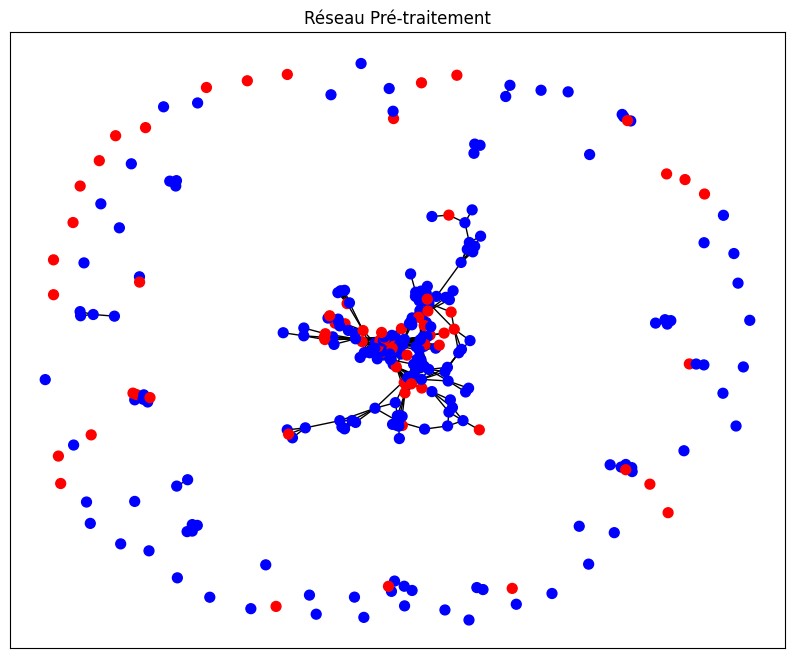

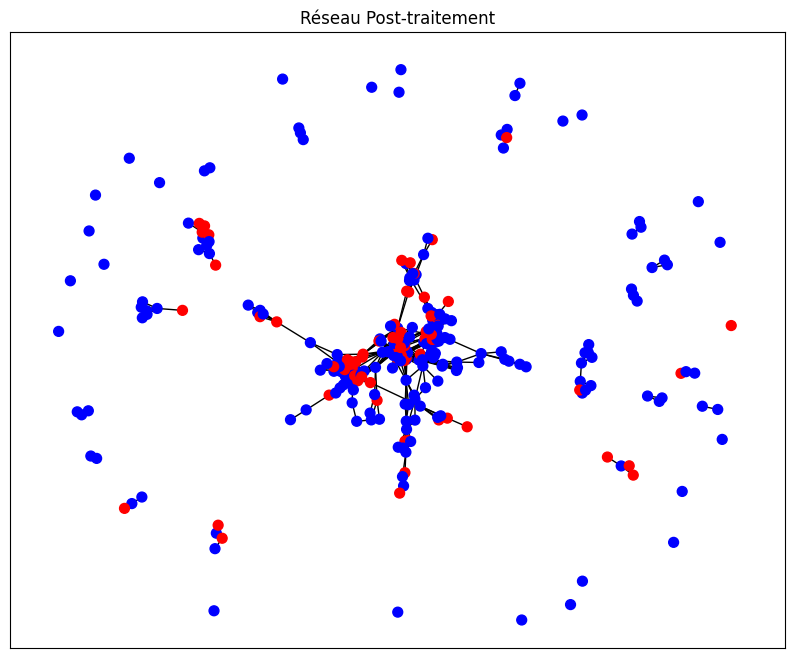

In [122]:
# Visualisation des réseaux
def plot_network(G, title, attr='gender'):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # Coloration par attribut
    colors = ['blue', 'red']
    node_colors = [colors[G.nodes[n][attr]] for n in G.nodes()]
    
    nx.draw_networkx(G, pos, node_color=node_colors, 
                     node_size=50, with_labels=False)
    plt.title(title)
    plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300)
    plt.show()

plot_network(G_pre, "Réseau Pré-traitement")
plot_network(G_post, "Réseau Post-traitement")

### **Interprétation des visualisations : Réseaux avant et après la politique**

#### **1. Réseau pré-traitement :**
- **Structure générale :**
  - Le réseau avant la politique montre une structure relativement fragmentée, avec plusieurs nœuds isolés ou faiblement connectés (visibles en périphérie du graphe).
  - Les nœuds centraux (au centre du graphe) sont connectés à plusieurs autres nœuds, formant des clusters denses. Ces clusters représentent probablement des sous-groupes ou des communautés fortement connectées.

- **Mixité des genres :**
  - Les nœuds rouges et bleus représentent probablement deux genres (par exemple, hommes et femmes).
  - Avant la politique, on observe une certaine séparation entre les genres, avec des clusters où les nœuds d'une même couleur (genre) sont majoritaires. Cela reflète une **homophilie par genre**, où les individus ont tendance à collaborer avec des personnes du même genre.

---

#### **2. Réseau post-traitement :**
- **Structure générale :**
  - Après la politique, le réseau semble plus intégré, avec une réduction du nombre de nœuds isolés et une augmentation des connexions entre les clusters.
  - Les clusters centraux sont plus denses, et les connexions entre les différents clusters semblent avoir augmenté, ce qui reflète une meilleure cohésion globale du réseau.

- **Mixité des genres :**
  - On observe une meilleure mixité des couleurs (genres) dans les clusters après la politique. Cela indique une réduction de l'homophilie par genre, avec davantage de collaborations entre individus de genres différents.
  - Les nœuds rouges et bleus sont plus répartis dans les clusters, ce qui reflète une intégration accrue des genres dans les collaborations.

---

#### **3. Impact de la politique :**
- La politique semble avoir eu un effet positif sur la structure du réseau :
  - **Réduction de la fragmentation :** Moins de nœuds isolés et une meilleure connectivité entre les clusters.
  - **Augmentation de la mixité :** Une réduction de l'homophilie par genre, favorisant des collaborations plus diversifiées et inclusives.
  - **Renforcement des clusters centraux :** Les individus centraux semblent avoir renforcé leur rôle, connectant davantage de nœuds et facilitant les interactions entre les sous-groupes.

---

#### **4. Lien avec votre projet :**
- Si votre projet vise à évaluer l'impact d'une politique sur les collaborations, ces visualisations montrent que la politique a contribué à :
  - Réduire les barrières entre les genres.
  - Favoriser une meilleure intégration des individus dans le réseau.
  - Renforcer la cohésion globale du réseau.

Ces résultats soutiennent l'idée que la politique a eu un effet structurant et inclusif sur le réseau.

---

#### **5. Conclusion :**
Les visualisations montrent clairement que la politique a permis de transformer la structure du réseau, en réduisant la fragmentation et en favorisant des collaborations plus diversifiées. Ces changements reflètent une meilleure intégration des genres et une cohésion accrue, ce qui est un indicateur fort de l'efficacité de la politique. Pour aller plus loin, il serait intéressant d'analyser quantitativement les changements dans les métriques globales et locales du réseau pour confirmer ces observations.

Nombre de chercheurs 'Core': 104
Nombre de chercheurs 'Non-Core': 206

--- Degré moyen par statut Core ---
Avant - Core: 7.0962, Non-Core: 4.8544
Après - Core: 7.8654, Non-Core: 8.2427

--- Centralités moyennes par statut Core ---
Degré Centrality Avant - Core: 0.0230, Non-Core: 0.0157
Degré Centrality Après - Core: 0.0255, Non-Core: 0.0267
Betweenness Centrality Avant - Core: 0.0068, Non-Core: 0.0037
Betweenness Centrality Après - Core: 0.0054, Non-Core: 0.0057

Test T - Degré Centrality Avant (Core vs Non-Core): p-value = 0.0071

Homophilie Core pré: 0.643
Homophilie Core post: 0.696


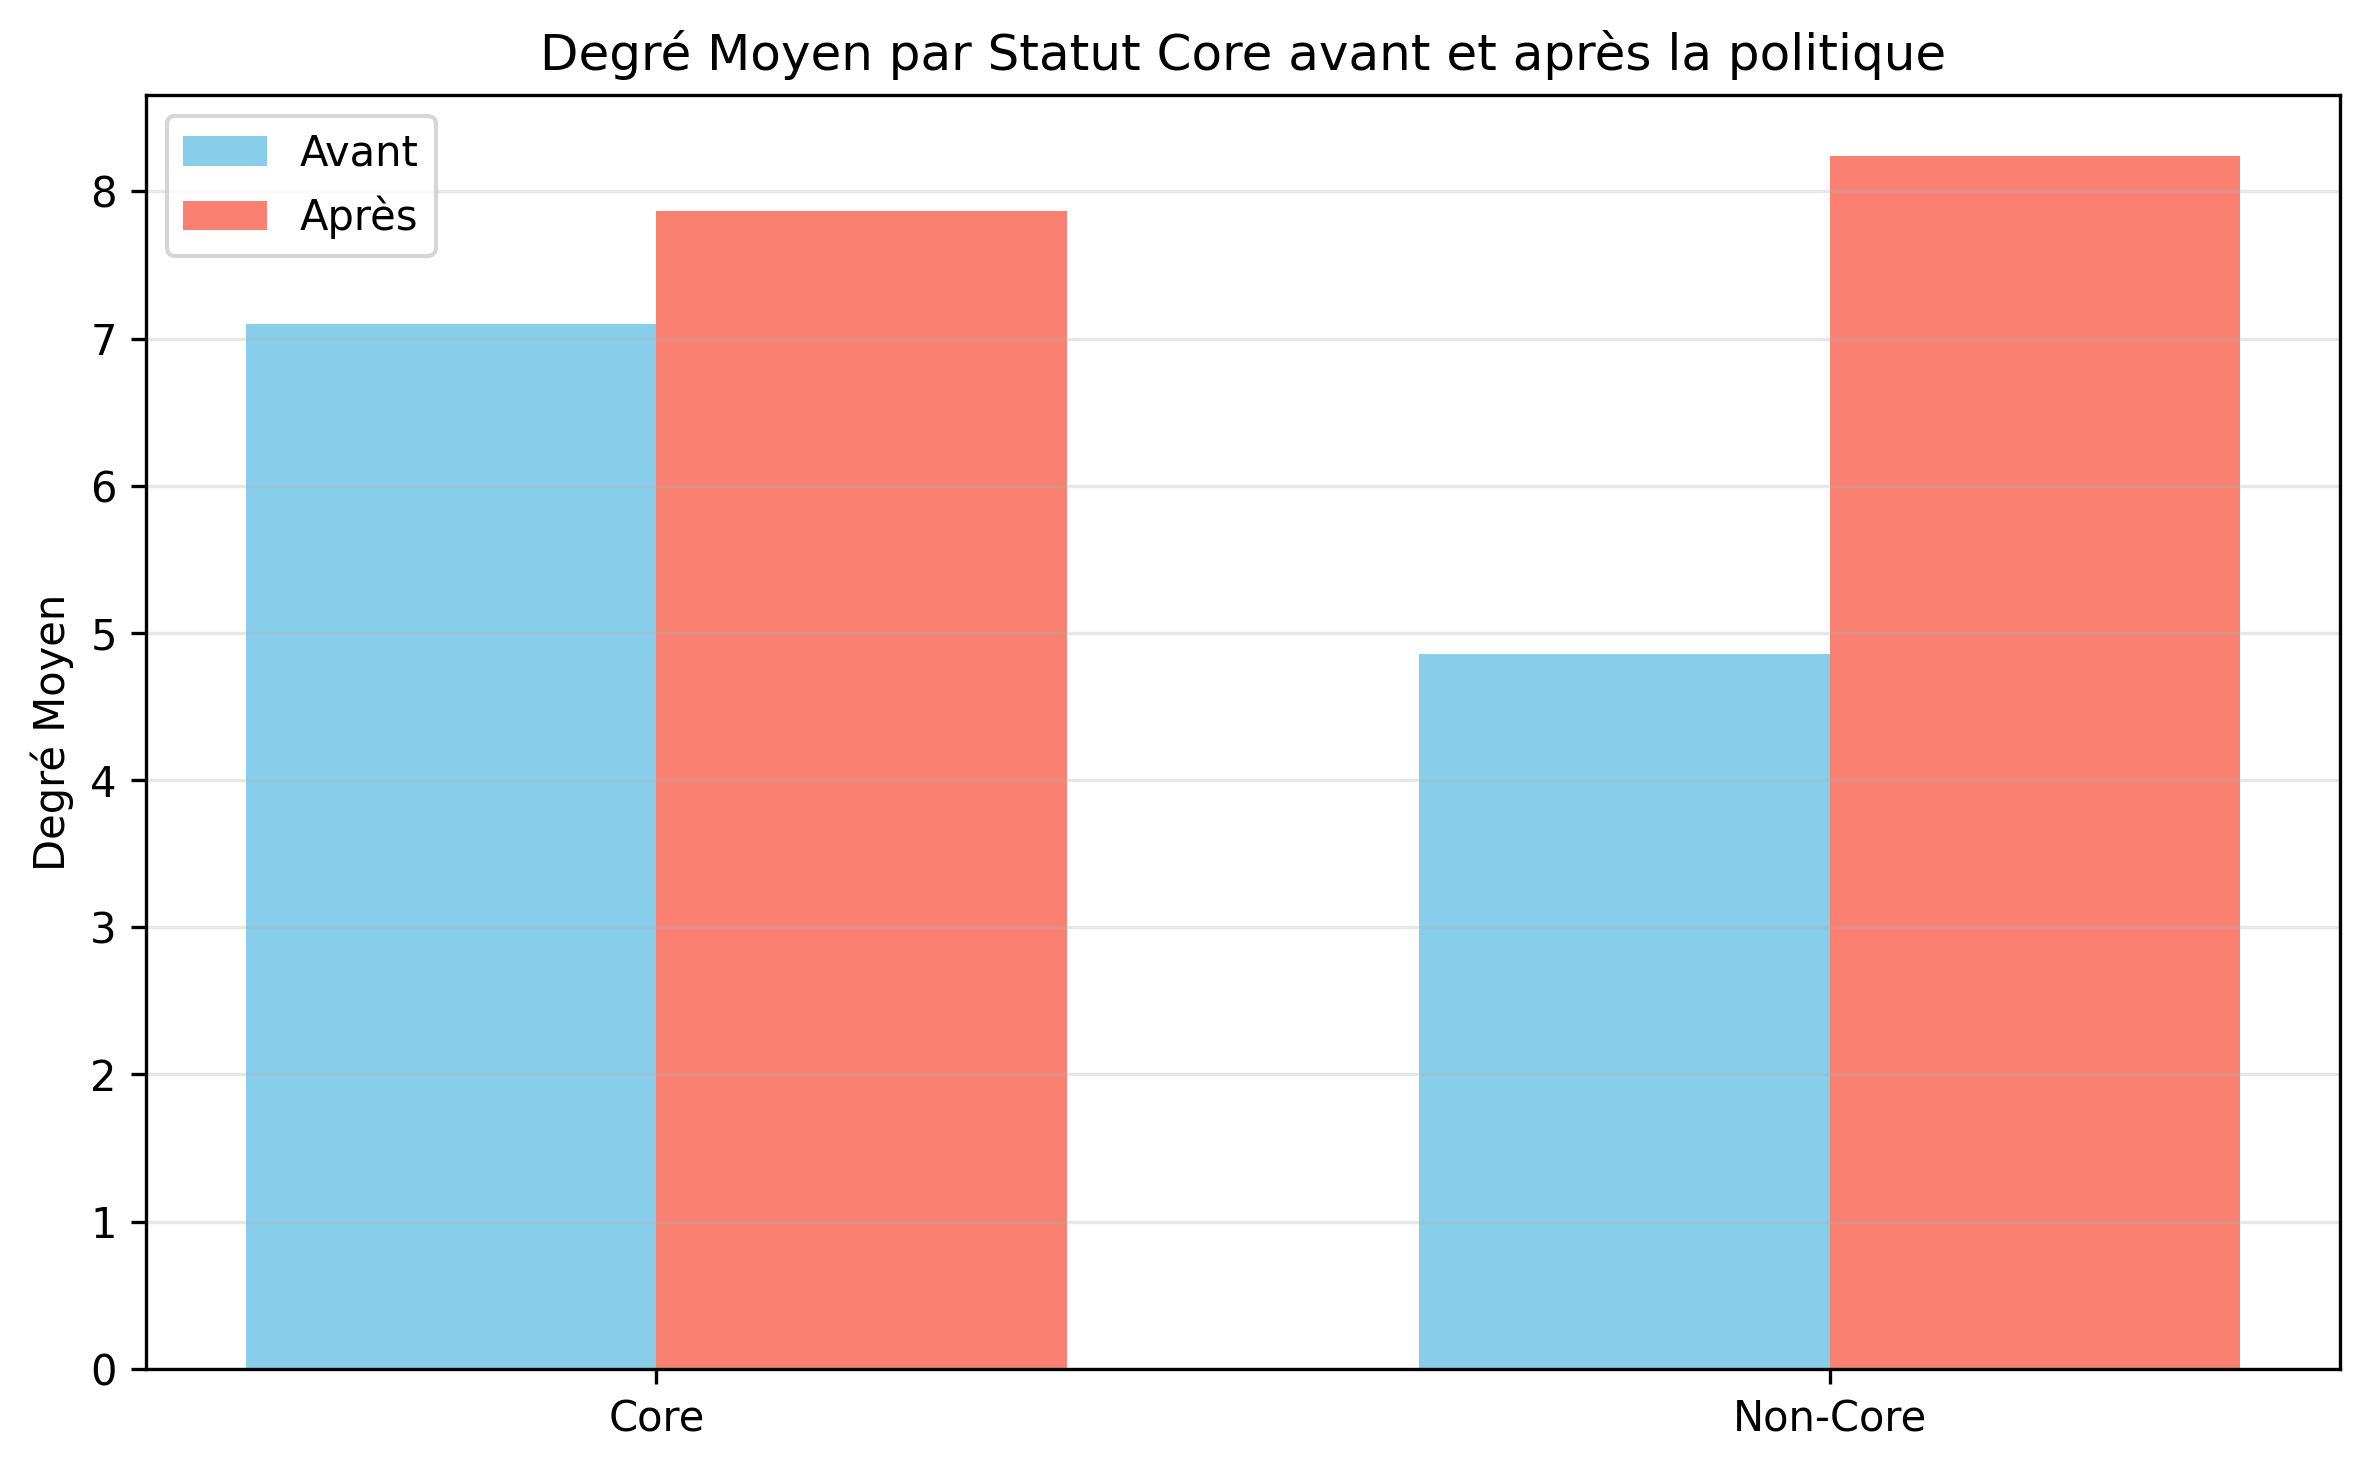

In [124]:
# --- 2. Analyse par Attribut "core" ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Identification des nœuds par statut "core"
core_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('core') == 1]
non_core_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('core') == 0]

# Nombre de nœuds
N_core = len(core_nodes)
N_non_core = len(non_core_nodes)

print(f"Nombre de chercheurs 'Core': {N_core}")
print(f"Nombre de chercheurs 'Non-Core': {N_non_core}")

# --- Degré moyen par Core ---
avg_degree_core_pre = sum(degree_pre.get(n, 0) for n in core_nodes) / N_core if N_core > 0 else 0
avg_degree_non_core_pre = sum(degree_pre.get(n, 0) for n in non_core_nodes) / N_non_core if N_non_core > 0 else 0
avg_degree_core_post = sum(degree_post.get(n, 0) for n in core_nodes) / N_core if N_core > 0 else 0
avg_degree_non_core_post = sum(degree_post.get(n, 0) for n in non_core_nodes) / N_non_core if N_non_core > 0 else 0

print("\n--- Degré moyen par statut Core ---")
print(f"Avant - Core: {avg_degree_core_pre:.4f}, Non-Core: {avg_degree_non_core_pre:.4f}")
print(f"Après - Core: {avg_degree_core_post:.4f}, Non-Core: {avg_degree_non_core_post:.4f}")

# --- Centralité moyenne par Core ---
avg_degree_cent_core_pre = np.mean([degree_centra_pre.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_degree_cent_non_core_pre = np.mean([degree_centra_pre.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0
avg_degree_cent_core_post = np.mean([degree_centra_post.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_degree_cent_non_core_post = np.mean([degree_centra_post.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0

avg_between_cent_core_pre = np.mean([between_centra_pre.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_between_cent_non_core_pre = np.mean([between_centra_pre.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0
avg_between_cent_core_post = np.mean([between_centra_post.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_between_cent_non_core_post = np.mean([between_centra_post.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0

print("\n--- Centralités moyennes par statut Core ---")
print(f"Degré Centrality Avant - Core: {avg_degree_cent_core_pre:.4f}, Non-Core: {avg_degree_cent_non_core_pre:.4f}")
print(f"Degré Centrality Après - Core: {avg_degree_cent_core_post:.4f}, Non-Core: {avg_degree_cent_non_core_post:.4f}")
print(f"Betweenness Centrality Avant - Core: {avg_between_cent_core_pre:.4f}, Non-Core: {avg_between_cent_non_core_pre:.4f}")
print(f"Betweenness Centrality Après - Core: {avg_between_cent_core_post:.4f}, Non-Core: {avg_between_cent_non_core_post:.4f}")

# Tests statistiques (exemple pour la centralité de degré avant)
deg_pre_core_vals = [degree_centra_pre.get(n, 0) for n in core_nodes]
deg_pre_non_core_vals = [degree_centra_pre.get(n, 0) for n in non_core_nodes]
if N_core > 0 and N_non_core > 0 and len(deg_pre_core_vals) > 1 and len(deg_pre_non_core_vals) > 1: # Vérifier qu'il y a assez de données
     t_stat_deg_pre_core, p_value_deg_pre_core = stats.ttest_ind(deg_pre_core_vals, deg_pre_non_core_vals, equal_var=False) # Welch's t-test
     print(f"\nTest T - Degré Centrality Avant (Core vs Non-Core): p-value = {p_value_deg_pre_core:.4f}")
else:
    print("\nPas assez de données pour effectuer le test T sur Degré Centrality Avant (Core vs Non-Core)")

# --- Homophilie par Core ---
# Utilise la fonction homophily définie précédemment
print(f"\nHomophilie Core pré: {homophily(G_pre, 'core'):.3f}")
print(f"Homophilie Core post: {homophily(G_post, 'core'):.3f}")

# --- Visualisation (Exemple pour le degré moyen) ---
labels = ['Core', 'Non-Core']
pre_values = [avg_degree_core_pre, avg_degree_non_core_pre]
post_values = [avg_degree_core_post, avg_degree_non_core_post]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
rects1 = ax.bar(x - width/2, pre_values, width, label='Avant', color='skyblue')
rects2 = ax.bar(x + width/2, post_values, width, label='Après', color='salmon')

ax.set_ylabel('Degré Moyen')
ax.set_title('Degré Moyen par Statut Core avant et après la politique')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

fig.tight_layout()
plt.savefig('degree_by_core.png', dpi=300)
plt.show()


--- Évolution du degré moyen par groupe (Interaction Genre x Core) ---
            Groupe    N  Degré Moyen Avant  Degré Moyen Après  \
0      Hommes Core   90             7.3556             7.9778   
1  Hommes Non-Core  144             4.7083             7.3681   
2      Femmes Core   14             5.4286             7.1429   
3  Femmes Non-Core   62             5.1935            10.2742   

   Changement Absolu  Changement (%)  
0             0.6222            8.46  
1             2.6597           56.49  
2             1.7143           31.58  
3             5.0806           97.83  


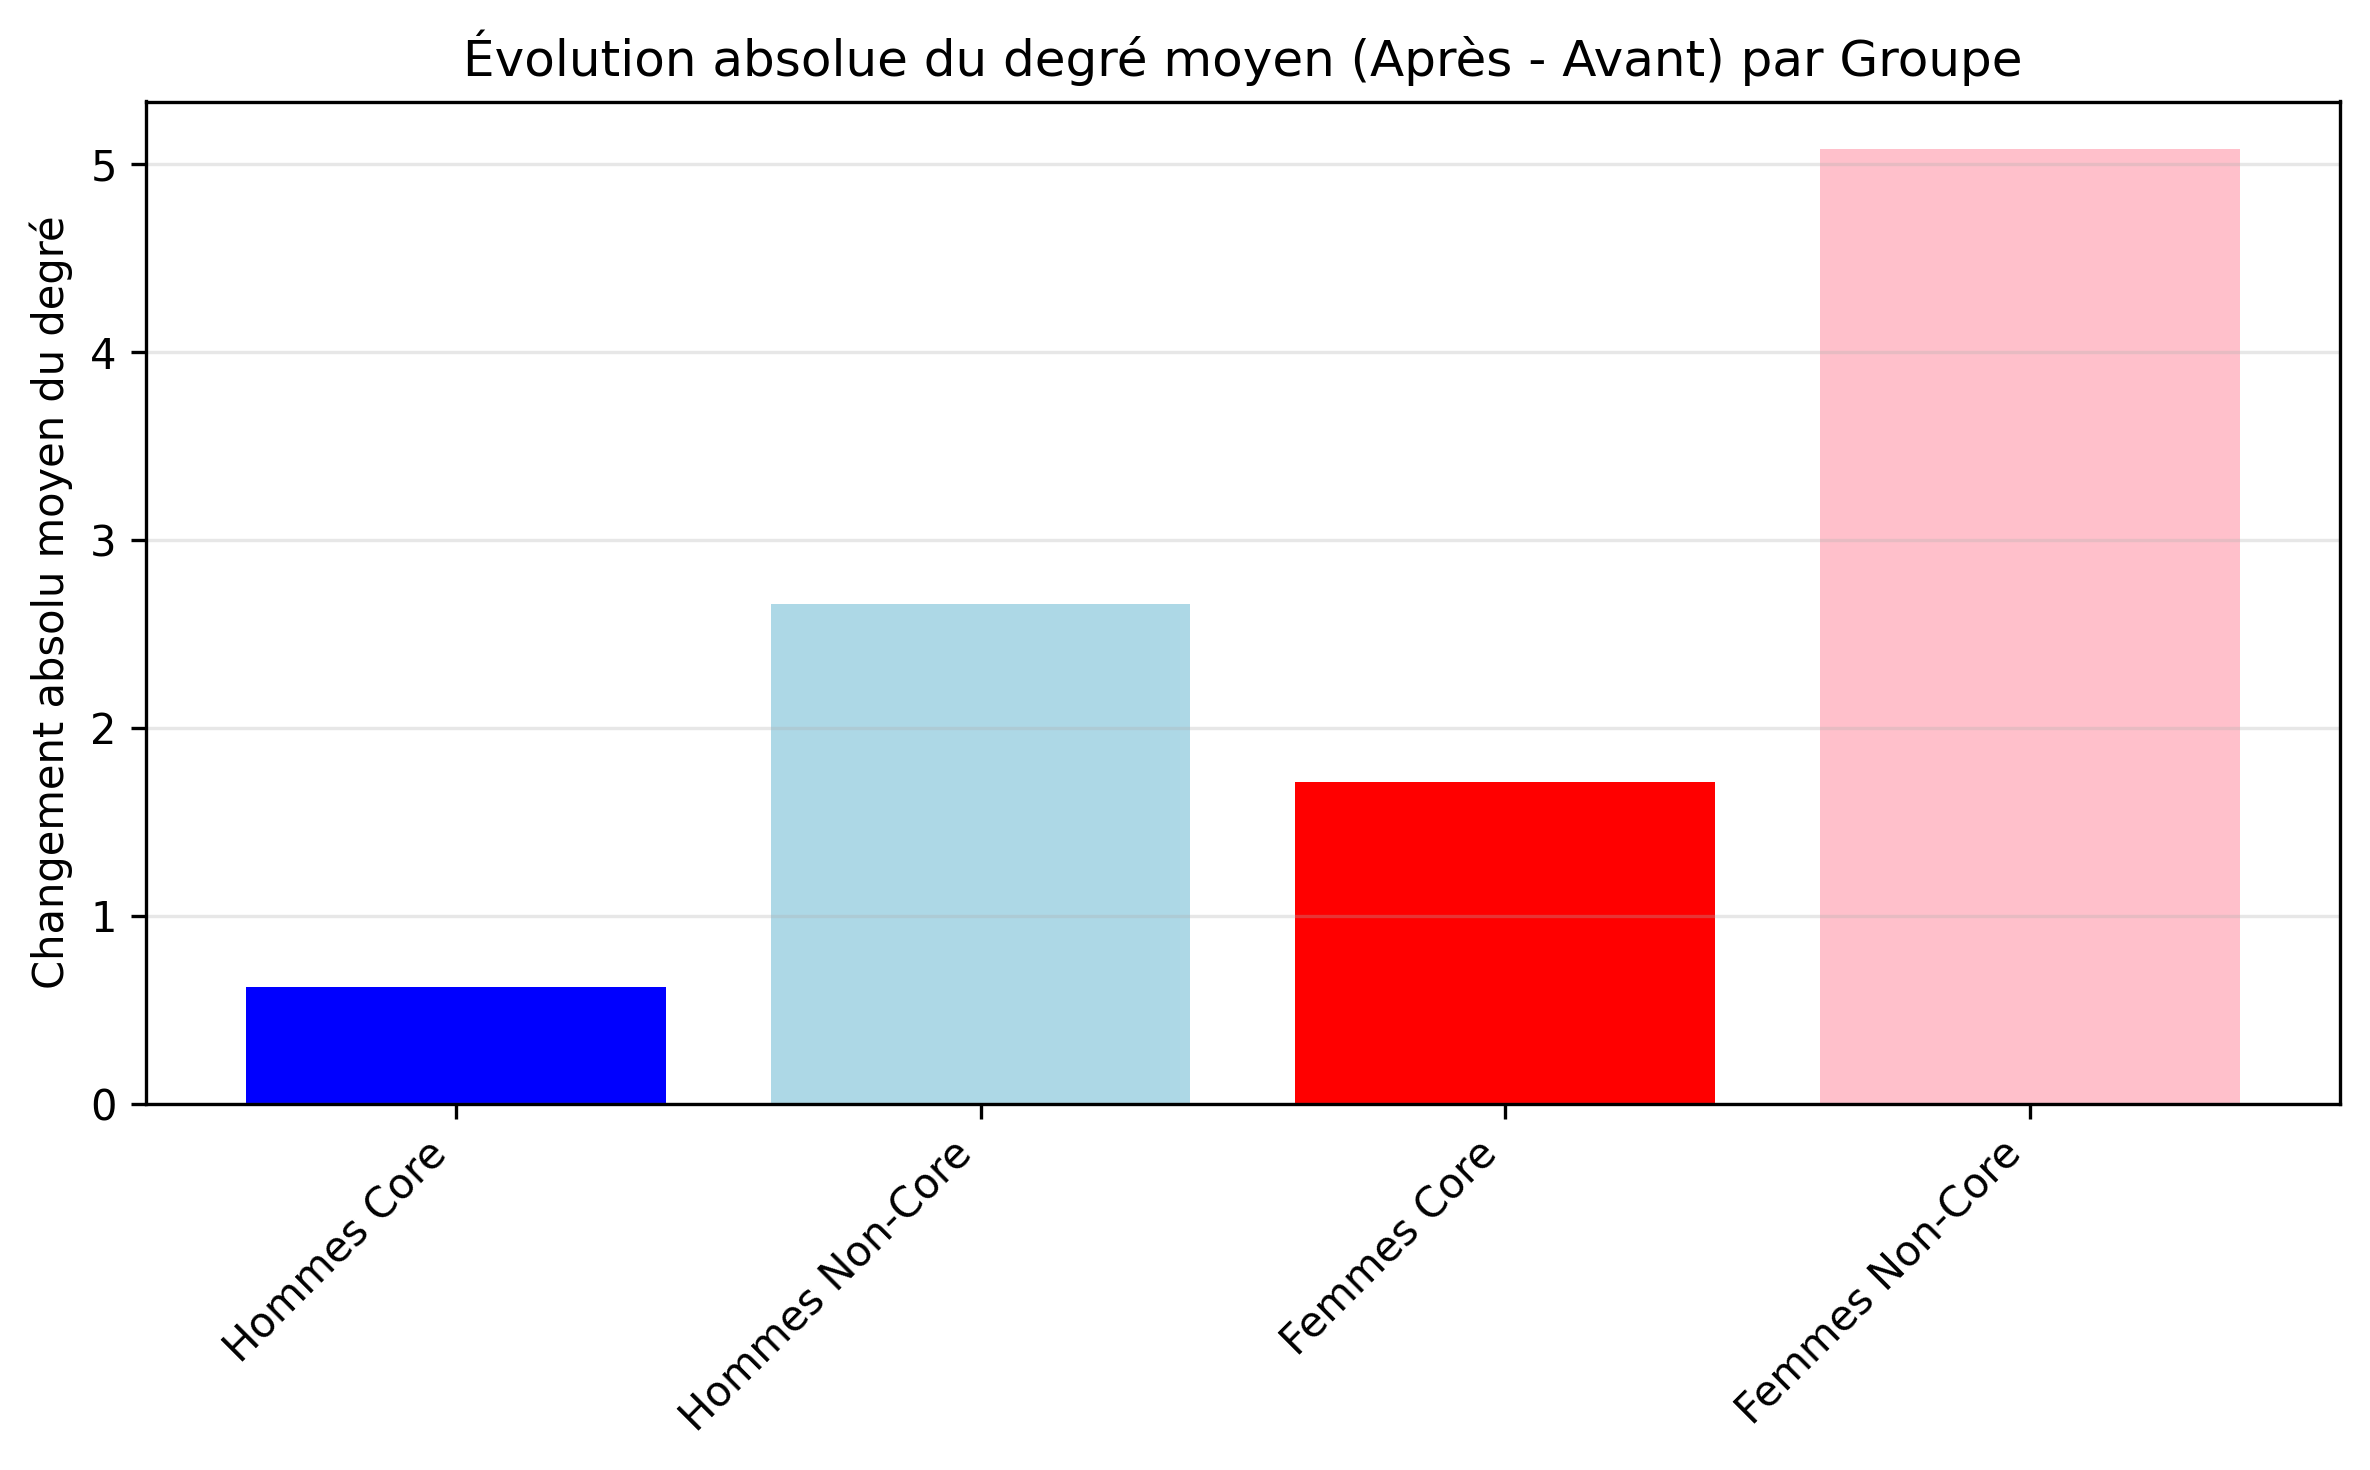

In [125]:
# --- 3. Analyse d'Interaction (Genre et Core) ---

# Définition des groupes
groups = {
    'Hommes Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0 and data.get('core') == 1],
    'Hommes Non-Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0 and data.get('core') == 0],
    'Femmes Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1 and data.get('core') == 1],
    'Femmes Non-Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1 and data.get('core') == 0]
}

# Calcul du degré moyen par groupe et évolution
results = []
for group_name, nodes_in_group in groups.items():
    N = len(nodes_in_group)
    if N > 0:
        avg_deg_pre = sum(degree_pre.get(n, 0) for n in nodes_in_group) / N
        avg_deg_post = sum(degree_post.get(n, 0) for n in nodes_in_group) / N
        change = avg_deg_post - avg_deg_pre
        change_pct = (change / avg_deg_pre * 100) if avg_deg_pre > 0 else np.inf # Utiliser infini si le degré avant est 0
        results.append({
            'Groupe': group_name,
            'N': N,
            'Degré Moyen Avant': round(avg_deg_pre, 4),
            'Degré Moyen Après': round(avg_deg_post, 4),
            'Changement Absolu': round(change, 4),
            'Changement (%)': round(change_pct, 2) if change_pct != np.inf else 'Inf'
        })

interaction_df = pd.DataFrame(results)
print("\n--- Évolution du degré moyen par groupe (Interaction Genre x Core) ---")
print(interaction_df)

# Visualisation du changement absolu moyen
plt.figure(figsize=(8, 5), dpi=300)
colors = ['blue', 'lightblue', 'red', 'pink']
plt.bar(interaction_df['Groupe'], interaction_df['Changement Absolu'], color=colors)
plt.ylabel("Changement absolu moyen du degré")
plt.title("Évolution absolue du degré moyen (Après - Avant) par Groupe")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('degree_change_interaction.png', dpi=300)
plt.show()

Dans ce projet, la distinction entre "Core" et "Non-Core" ne repose pas sur des propriétés de réseau, mais sur une identification préalable au traitement. Les membres "Core" (core = 1) sont des personnes qui ont été identifiées comme membres centraux ou experts dans leur domaine de compétence. Cette désignation reflète leur niveau d'expertise ou leur position reconnue dans l'espace professionnel, indépendamment de leur position initiale dans le réseau social.

## Interprétation globale des résultats

L'analyse révèle une transformation significative du réseau suite à l'intervention:

### 1. Densification et cohésion du réseau global

Le réseau a connu une densification remarquable avec une augmentation de 44,76% du nombre de liens, tout en maintenant le même nombre de participants (310). Cette densification s'accompagne d'une hausse significative des coefficients de clustering (+26,23% pour le coefficient local), indiquant la formation de communautés plus cohésives. La distance moyenne entre les participants a diminué de 5,05%, facilitant une circulation plus efficace de l'information. De plus, la composante principale du réseau s'est élargie (+12,04%), intégrant davantage de participants au groupe principal.

### 2. Dynamiques différenciées selon le genre et l'expertise

L'impact de l'intervention varie considérablement selon les groupes:

- **Femmes Non-Core**: Ce groupe a connu la transformation la plus spectaculaire (+97,83% de connectivité). Ces femmes, initialement non identifiées comme expertes, ont presque doublé leur nombre moyen de connexions, passant de 5,19 à 10,27. Elles sont devenues le groupe le plus connecté après l'intervention, dépassant même les hommes experts.

- **Hommes Non-Core**: Leur connectivité a également fortement progressé (+56,49%), mais dans une moindre mesure que leurs homologues féminines.

- **Femmes Core**: Malgré leur statut d'expertes, elles partaient d'un niveau de connectivité relativement modeste (5,43) qui a augmenté de 31,58%.

- **Hommes Core**: Ce groupe, initialement le plus connecté (7,36), a connu la progression la plus faible (+8,46%), suggérant un possible effet plafond.

### 3. Implications et conclusions

Ces résultats suggèrent que l'intervention a eu un effet "égalisateur" et inclusif, bénéficiant particulièrement aux groupes initialement moins intégrés dans le réseau. L'effet le plus marquant concerne les femmes non-expertes, dont l'intégration spectaculaire pourrait indiquer:

1. Une réduction des barrières invisibles limitant leur participation
2. Une meilleure reconnaissance de leurs contributions
3. Une transformation des dynamiques sociales favorisant l'inclusion

L'intervention semble avoir créé un environnement où l'expertise formelle (statut "Core") devient moins déterminante pour la centralité dans le réseau, particulièrement pour les femmes. Cette évolution pourrait favoriser l'émergence de nouvelles voix et perspectives, enrichissant potentiellement l'écosystème professionnel dans son ensemble.


--- Analyse de la composition des communautés (Avant) ---
       ID Communauté     Taille  Proportion Femmes  Proportion Core
count       91.00000  91.000000          91.000000        91.000000
mean        45.00000   3.406593           0.297846         0.201956
std         26.41338   7.466932           0.426763         0.382775
min          0.00000   1.000000           0.000000         0.000000
25%         22.50000   1.000000           0.000000         0.000000
50%         45.00000   1.000000           0.000000         0.000000
75%         67.50000   1.500000           0.750000         0.041500
max         90.00000  50.000000           1.000000         1.000000

--- Analyse de la composition des communautés (Après) ---
       ID Communauté     Taille  Proportion Femmes  Proportion Core
count      53.000000  53.000000          53.000000        53.000000
mean       26.000000   5.849057           0.131151         0.289925
std        15.443445   9.983441           0.219256         0.38549

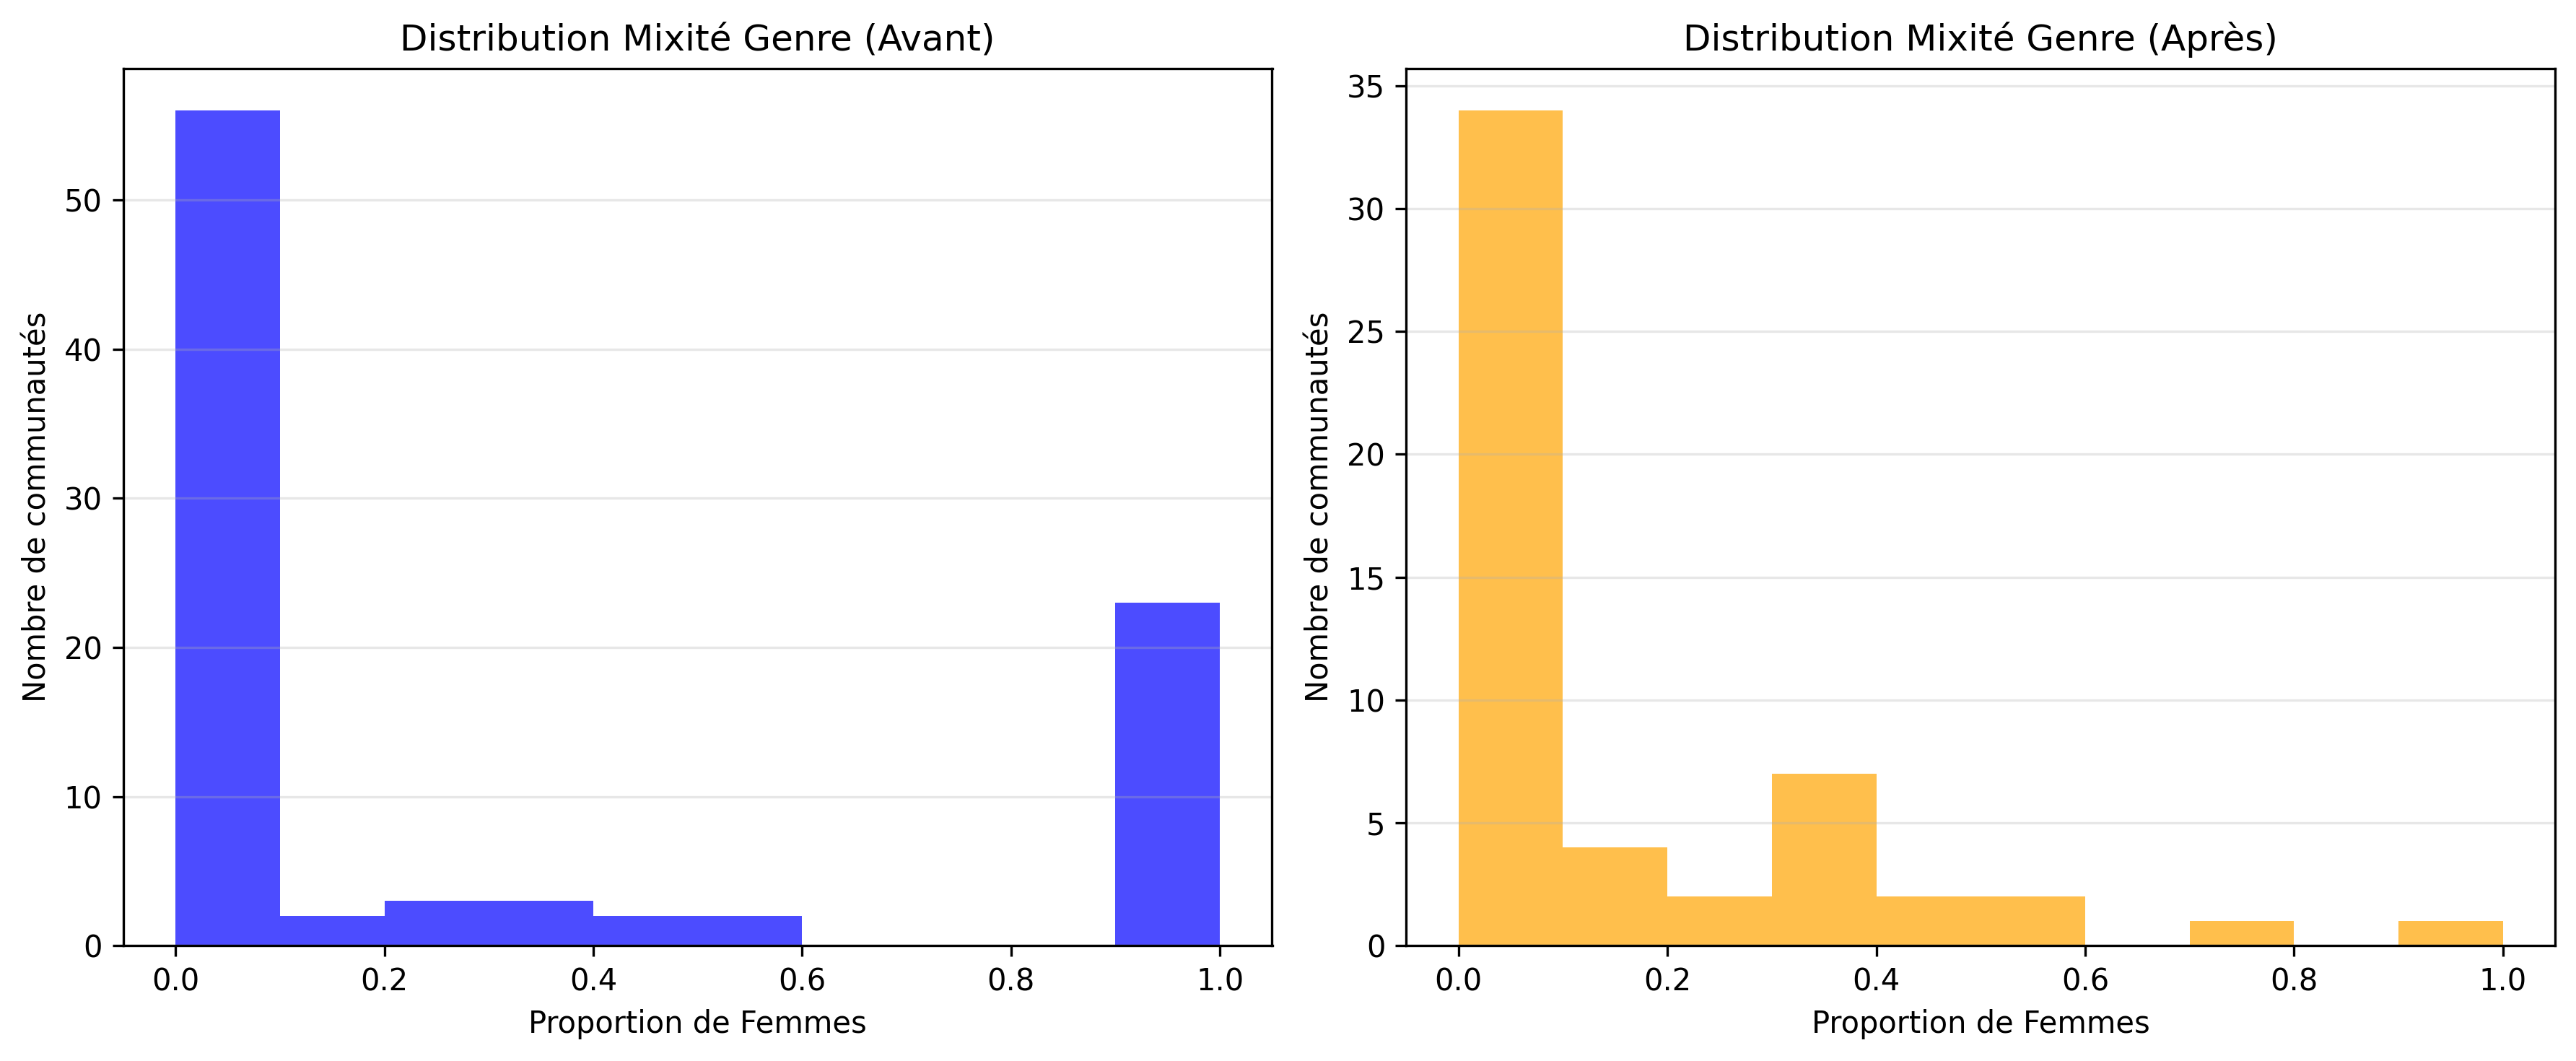

In [129]:
# --- 4. Analyse des Communautés ---

def analyze_communities(G, communities, period_name):
    if not communities: return {} # Gérer le cas où aucune communauté n'est trouvée

    results = []
    for i, comm in enumerate(communities):
        comm_size = len(comm)
        if comm_size == 0: continue

        genders = [G.nodes[n].get('gender', np.nan) for n in comm] # Utiliser nan pour les valeurs manquantes
        cores = [G.nodes[n].get('core', np.nan) for n in comm]

        valid_genders = [g for g in genders if not np.isnan(g)]
        valid_cores = [c for c in cores if not np.isnan(c)]

        prop_female = sum(g == 1 for g in valid_genders) / len(valid_genders) if len(valid_genders) > 0 else 0
        prop_core = sum(c == 1 for c in valid_cores) / len(valid_cores) if len(valid_cores) > 0 else 0

        results.append({
            'Période': period_name,
            'ID Communauté': i,
            'Taille': comm_size,
            'Proportion Femmes': round(prop_female, 3),
            'Proportion Core': round(prop_core, 3)
        })
    return pd.DataFrame(results)

communities_pre_df = analyze_communities(G_pre, pre_comm, "Avant")
communities_post_df = analyze_communities(G_post, post_comm, "Après")

print("\n--- Analyse de la composition des communautés (Avant) ---")
print(communities_pre_df.describe()) # Afficher statistiques descriptives

print("\n--- Analyse de la composition des communautés (Après) ---")
print(communities_post_df.describe()) # Afficher statistiques descriptives

# Visualisation 
plt.figure(figsize=(12, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.hist(communities_pre_df['Proportion Femmes'], bins=10, alpha=0.7, color='blue')
plt.xlabel("Proportion de Femmes")
plt.ylabel("Nombre de communautés")
plt.title("Distribution Mixité Genre (Avant)")
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(communities_post_df['Proportion Femmes'], bins=10, alpha=0.7, color='orange')
plt.xlabel("Proportion de Femmes")
plt.ylabel("Nombre de communautés")
plt.title("Distribution Mixité Genre (Après)")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('community_gender_mix_distribution.png', dpi=300)
plt.show()


In [131]:
# --- 5. Analyse Explicite de l'Évolution des Métriques Globales ---

if 'Valeurs avant la politique' in metrics_df.index and 'Valeurs après la politique' in metrics_df.index:
     metrics_pre = metrics_df.loc['Valeurs avant la politique']
     metrics_post = metrics_df.loc['Valeurs après la politique']

     # Éviter la division par zéro
     metrics_pre_safe = metrics_pre.replace(0, np.nan)

     # Calculer l'évolution en pourcentage, ignorer les NaN
     evolution_pct = ((metrics_post - metrics_pre) / metrics_pre_safe * 100).round(2).fillna(0) # Remplacer NaN (division par 0) par 0% ou 'Inf'

     # Calculer l'évolution absolue
     evolution_abs = (metrics_post - metrics_pre).round(4)

     evolution_df = pd.DataFrame({
         'Avant': metrics_pre,
         'Après': metrics_post,
         'Évolution Absolue': evolution_abs,
         'Évolution (%)': evolution_pct
     })

     print("\n--- Évolution des Métriques Globales du Réseau ---")
     print(evolution_df)
else:
    print("\nImpossible de calculer l'évolution, metrics_df incomplet.")


--- Évolution des Métriques Globales du Réseau ---
                                                   Avant      Après  \
Nombre de nœuds (ordre)                         310.0000   310.0000   
Nombre de liens (taille)                        869.0000  1258.0000   
Degré moyen du réseau                             5.6060     8.1160   
Densité du réseau                                 0.0181     0.0263   
Average local clustering coefficient              0.4460     0.5630   
Global clustering coefficient                     0.5413     0.6708   
Average shortest path (plus grande composante)    4.8651     4.6196   
% nœuds dans plus grande composante              61.6100    69.0300   

                                                Évolution Absolue  \
Nombre de nœuds (ordre)                                    0.0000   
Nombre de liens (taille)                                 389.0000   
Degré moyen du réseau                                      2.5100   
Densité du réseau               